# **Efficient credit card fraud detection using evolutionary hybrid feature selection and random weight networks**

The objective of this notebook is to implement a method for credit card fraud detection, as described in the paper "Efficient credit card fraud detection using evolutionary hybrid feature selection and random weight networks" by Enas Rawashdeha, Nancy Al-Ramahib, Hadeel Ahmadc, and Rawan Zaghloul, published in the International Journal of Data and Network Science (https://www.growingscience.com/ijds/Vol8/ijdns_2023_157.pdf).

In the realm of financial security, the detection and prevention of credit card fraud has become paramount. With the ever-increasing reliance on digital transactions, the risk of fraudulent activities targeting credit card systems has grown significantly. To combat this, sophisticated techniques are required to swiftly identify and mitigate potential threats. Machine learning, a cornerstone of modern data analysis, has emerged as a powerful tool in this pursuit. By leveraging vast datasets and employing advanced algorithms, machine learning enables the automated scrutiny of transactions, distinguishing between legitimate and fraudulent activities with remarkable precision.
The paper introduces an intelligent method for credit card fraud detection that relies on Competitive Swarm Optimization (CSO) and Random Weight Network (RWN). Additionally, the system includes an automated hybrid feature selection capability to identify the most pertinent features during the detection process. The experimental outcomes validate that this system can attain outstanding results in G-Mean, RUC, and Recall values.

In [1]:
# Fix randomness and hide warnings
seed = 42

import numpy as np
np.random.seed(seed)
import pandas as pd
from tqdm.notebook import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.stats import skew

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", color_codes=True)

from itertools import chain, combinations
from joblib import Parallel, delayed
import json

import warnings
warnings.simplefilter(action='ignore', category=Warning)
os.environ['PYTHONWARNINGS'] = 'ignore'

from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/NAML Project/Datasets/'

Mounted at /content/drive


### Handling missing values


*   kNN Mean Imputation for numerical features
*   kNN Majority Vote Imputation for categorical features
*   Removal of samples with missing values in multiple categorical features simultaneously

In [2]:
def majority_vote_imputation(df, df_imputed, classifier, categorical_cols, n_neighbors) -> pd.DataFrame:
  for col in categorical_cols:
    to_impute = df[df[col].isna() & df.drop(columns=col).notna().all(axis=1)].copy()
    for i in range(len(to_impute)):
      sample = to_impute.drop(columns=col).iloc[i]
      to_impute[col].iloc[i] = classifier[col].predict([sample])[0]
    df_imputed = pd.concat([df_imputed, to_impute])
  return df_imputed


def kNN_Imputation(X_train, X_valid, X_test, categorical_cols, numerical_cols) -> pd.DataFrame:
  n_neighbors = 3

  # Label encoding of categorical features
  encoders = {}
  # Encode categorical features with value between 0 and n_classes-1
  for col in categorical_cols:
    encoder = LabelEncoder()
    idxs = X_train[col].notnull()
    X_train.loc[idxs, col] = encoder.fit_transform(X_train.loc[idxs, col])
    # Store the fitted LabelEncoders for each categorical column
    encoders[col] = encoder

  for df in [X_valid, X_test]:
    # Encode categorical features with value between 0 and n_classes-1
    for col in categorical_cols:
      idxs = df[col].notnull()
      df.loc[idxs, col] = encoders[col].transform(df.loc[idxs, col])

  # kNN Mean Imputation for numerical features
  # Each sample’s missing values in the numerical features are imputed using the mean value from kNN found in the training set
  X_train_imputed = X_train.dropna(subset=categorical_cols)
  imputer = KNNImputer(n_neighbors=n_neighbors).fit(X_train_imputed)
  X_train_imputed = pd.DataFrame(
      imputer.transform(X_train_imputed),
      columns=X_train.columns,
      index=X_train_imputed.index
  )

  X_valid_imputed = X_valid.dropna(subset=categorical_cols)
  X_valid_imputed = pd.DataFrame(
      imputer.transform(X_valid_imputed),
      columns = X_valid.columns,
      index = X_valid_imputed.index
  )

  X_test_imputed = X_test.dropna(subset=categorical_cols)
  X_test_imputed = pd.DataFrame(
      imputer.transform(X_test_imputed),
      columns = X_test.columns,
      index = X_test_imputed.index
  )

  # kNN Majority Vote Imputation for categorical features
  classifier = {}
  for col in categorical_cols:
    # Store the fitted KNeighborsClassifier for each categorical column
    classifier[col] = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
        X_train.dropna().drop(columns=col),
        X_train.dropna()[col].astype(int)
    )

  X_train_imputed = majority_vote_imputation(X_train, X_train_imputed, classifier, categorical_cols, n_neighbors)
  X_valid_imputed = majority_vote_imputation(X_valid, X_valid_imputed, classifier, categorical_cols, n_neighbors)
  X_test_imputed = majority_vote_imputation(X_test, X_test_imputed, classifier, categorical_cols, n_neighbors)

  print("Removing samples with missing values in multiple categorical features simultaneously ...")
  print(f"Training set samples removed: {len(X_train)-len(X_train_imputed)} ({(len(X_train)-len(X_train_imputed))/len(X_train):.2%})")
  print(f"Validation set samples removed: {len(X_valid)-len(X_valid_imputed)} ({(len(X_valid)-len(X_valid_imputed))/len(X_valid):.2%})")
  print(f"Test set samples removed: {len(X_test)-len(X_test_imputed)} ({(len(X_test)-len(X_test_imputed))/len(X_test):.2%})")

  # Transform the encoded categorical features back
  for df in [X_train_imputed, X_valid_imputed, X_test_imputed]:
    for col in categorical_cols:
      df[col] = encoders[col].inverse_transform(df[col].astype(int))
  return X_train_imputed.sort_index(), X_valid_imputed.sort_index(), X_test_imputed.sort_index()

### Synthetic Minority Over-sampling Technique (SMOTE)
Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in the dataset in a balanced way. The component works by generating new instances from existing minority cases supplied as input, without altering the number of majority class cases.
The new instances are not just copies of existing minority cases. Instead, the algorithm takes samples of the feature space for each target class and its nearest neighbors. The algorithm then generates new examples that combine features of the target case with features of its neighbors. This approach increases the features available to each class and makes the samples more general.

In [3]:
def perform_SMOTE(X_train, y_train, categorical_cols) -> tuple:
  X = X_train.copy()
  # Label encoding of categorical features
  encoders = {}
  # Encode categorical features with value between 0 and n_classes-1
  for col in categorical_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    # Store the fitted LabelEncoders for each categorical column
    encoders[col] = encoder
  y_encoder = LabelEncoder()
  y = y_encoder.fit_transform(y_train)
  X_res, y_res = SMOTE(random_state=seed).fit_resample(X, y)
  # Transform the encoded categorical features back
  for col in categorical_cols:
    X_res[col] = encoders[col].inverse_transform(X_res[col].astype(int))
  y_res = pd.Series(
      y_encoder.inverse_transform(y_res.astype(int)), name=y_train.name)
  return X_res, y_res

# Dataset 1 - Loan Prediction
https://github.com/Paliking/ML_examples/blob/master/LoanPrediction/train_u6lujuX_CVtuZ9i.csv


## Dataset Analysis

In [ ]:
dataset = pd.read_csv(path + 'LoanPrediction.csv')

# Remove Loan_ID column
dataset.drop('Loan_ID', axis=1, inplace=True)

# Retrieve the categorical columns from the dataframe
categorical_cols = dataset.iloc[:, :-1].select_dtypes(include=['object']).columns.tolist()
# Retrieve the numerical columns from the dataframe
numerical_cols = dataset.iloc[:, :-1].columns.difference(categorical_cols).tolist()

n_features = len(dataset.columns) - 1

print(f"# samples = {len(dataset)}")
print(f"# features = {n_features}")
print(f"target: {dataset.columns[-1]}")

# samples = 614
# features = 11
target: Loan_Status


In [ ]:
dataset

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0      Male      No          0      Graduate            No             5849   
1      Male     Yes          1      Graduate            No             4583   
2      Male     Yes          0      Graduate           Yes             3000   
3      Male     Yes          0  Not Graduate            No             2583   
4      Male      No          0      Graduate            No             6000   
..      ...     ...        ...           ...           ...              ...   
609  Female      No          0      Graduate            No             2900   
610    Male     Yes         3+      Graduate            No             4106   
611    Male     Yes          1      Graduate            No             8072   
612    Male     Yes          2      Graduate            No             7583   
613  Female      No          0      Graduate           Yes             4583   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                  0.0         NaN             360.0             1.0   
1               1508.0       128.0             360.0             1.0   
2                  0.0        66.0             360.0             1.0   
3               2358.0       120.0             360.0             1.0   
4                  0.0       141.0             360.0             1.0   
..                 ...         ...               ...             ...   
609                0.0        71.0             360.0             1.0   
610                0.0        40.0             180.0             1.0   
611              240.0       253.0             360.0             1.0   
612                0.0       187.0             360.0             1.0   
613                0.0       133.0             360.0             0.0   

    Property_Area Loan_Status  
0           Urban           Y  
1           Rural           N  
2           Urban           Y  
3           Urban           Y  
4           Urban           Y  
..            ...         ...  
609         Rural           Y  
610         Rural           Y  
611         Urban           Y  
612         Urban           Y  
613     Semiurban           N  

[614 rows x 12 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


### Skewness

Skewness is a statistical measure that quantifies the asymmetry of the distribution of values in a dataset. It indicates whether the data points are skewed to the left (negative skew) or the right (positive skew) relative to the mean.

*   **Positive Skewness (Right Skew)**: the majority of data points are concentrated on the left side of the distribution, with a few extreme values on the right side.
<center> Mean > Median > Mode </center>

*   **Negative Skewness (Left Skew)**: most of the data points are concentrated on the right side of the distribution, while a few extreme values on the left side.
<center> Mean < Median < Mode </center>

*   **Zero Skewness (Symmetrical Distribution)**: perfectly symmetrical distribution, where the mean, median, and mode are equal. In such a distribution, the data points are evenly distributed around the central point.

In [ ]:
# Compute the skewness only for non missing variables
skewed_feats = dataset[numerical_cols].apply(lambda x: skew(x.dropna()))
skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
skewness

Variable  Skewness
0    ApplicantIncome  6.523526
1  CoapplicantIncome  7.473217
2     Credit_History -1.877351
3         LoanAmount  2.670763
4   Loan_Amount_Term -2.356504

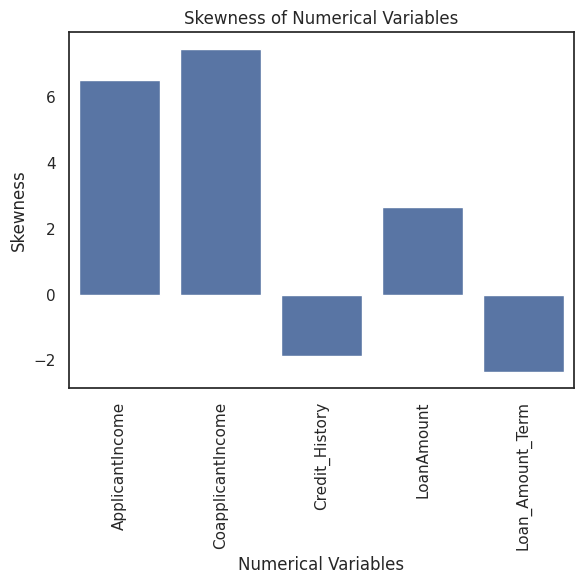

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.xticks(rotation=90)
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.xlabel('Numerical Variables')
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Variables')
plt.tight_layout()
plt.show()

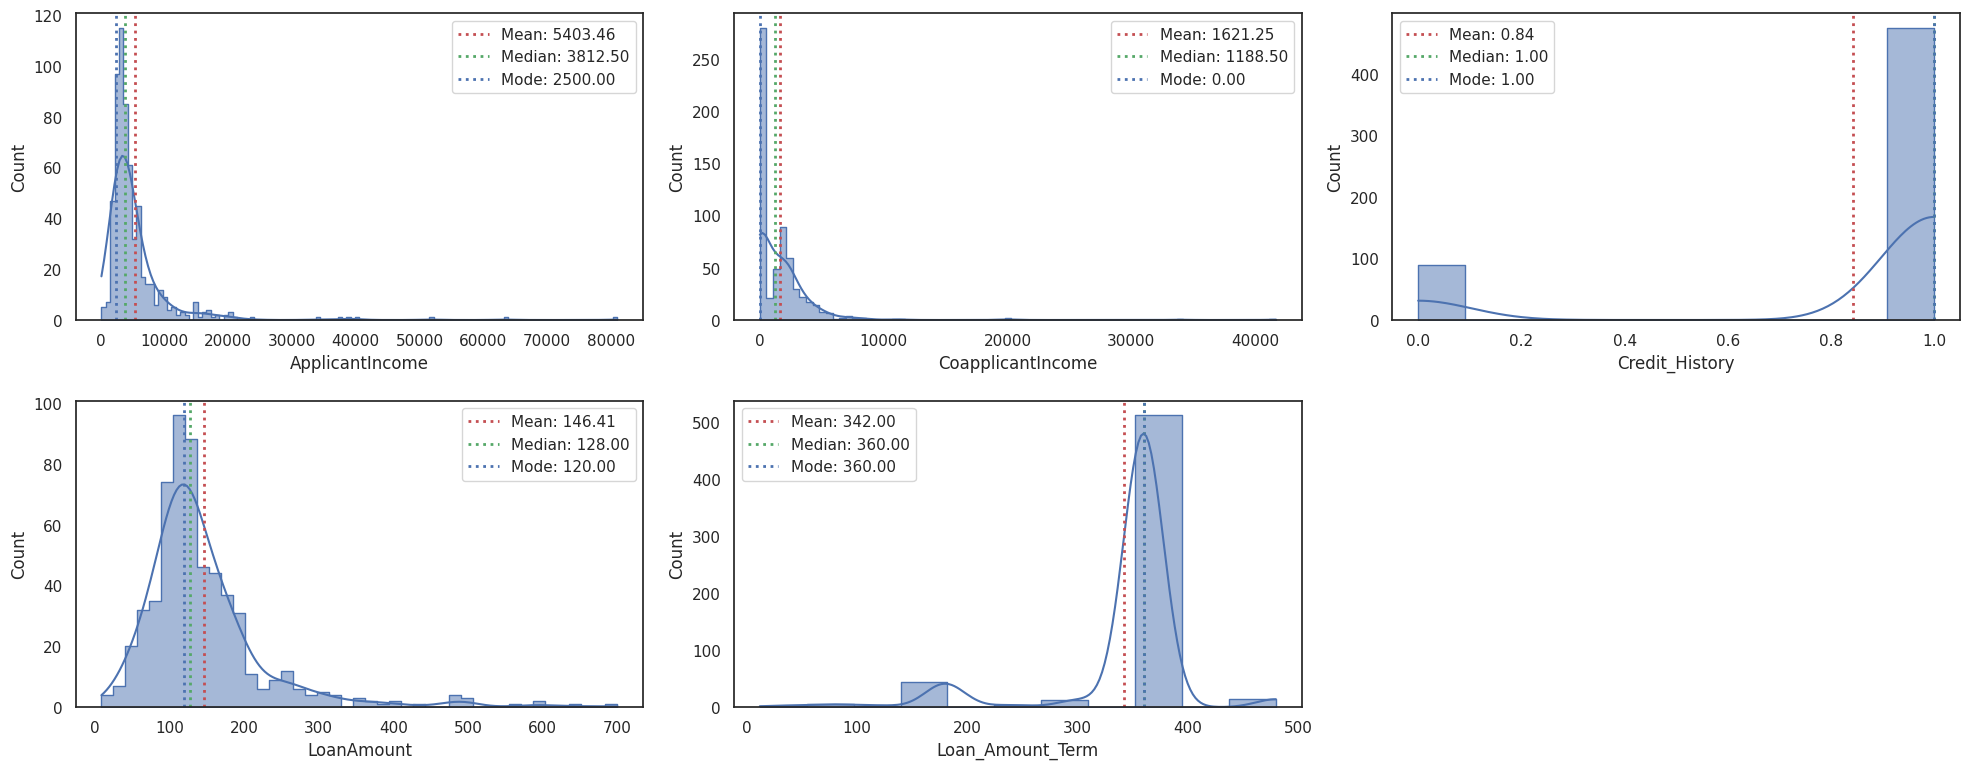

In [ ]:
fig, axs = plt.subplots(nrows = np.ceil(len(numerical_cols)/3).astype(int), ncols = 3, figsize = (20,8))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
  sns.histplot(dataset[col], kde=True, element="step", ax=axs[i])

  mean_value = dataset[col].mean()
  median_value = dataset[col].median()
  mode_value = dataset[col].mode()[0]
  axs[i].axvline(mean_value, color='r', linestyle=':', linewidth=2, label=f'Mean: {mean_value:.2f}')
  axs[i].axvline(median_value, color='g', linestyle=':', linewidth=2, label=f'Median: {median_value:.2f}')
  axs[i].axvline(mode_value, color='b', linestyle=':', linewidth=2, label=f'Mode: {mode_value:.2f}')
  axs[i].legend()

# Hide the unutilized axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(pad=1.5)
plt.show()

### Correlation Analysis

Compute pairwise correlation of columns, using Pearson correlation coefficient

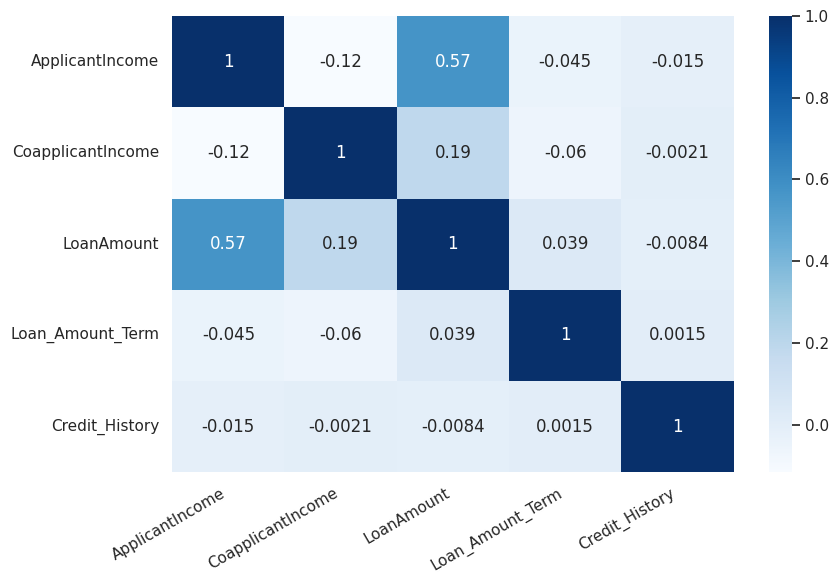

In [ ]:
corrmat = dataset.corr(numeric_only=True)

fig, axs = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, annot=True, cmap="Blues")
plt.xticks(rotation=30, ha='right')
fig.tight_layout()
plt.show()

LoanAmount exhibits a moderate positive linear correlation with ApplicantIncome, while showing a very weak positive linear correlation with both CoapplicantIncome and Loan_Amount_Term. Additionally, Loan_Amount_Term also demonstrates a very weak positive linear correlation with Credit_History. The remaining numerical features are characterized by very weak negative linear correlations.

### Dataset splitting
The dataset has been split into training, validation and test sets, with proportions of 70%, 15% and 15%, respectively.

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset.iloc[:, :-1],
    dataset.iloc[:, -1],
    test_size = 0.15,
    random_state = seed
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.1764,
    random_state = seed
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(dataset):.2%})")
print(f"Validation set size: {len(X_valid)} ({len(X_valid)/len(dataset):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(dataset):.2%})")

del X_train_val, y_train_val

Training set size: 429 (69.87%)
Validation set size: 92 (14.98%)
Test set size: 93 (15.15%)


### Missing values

In [ ]:
dataset_na = (dataset.isna().sum() / len(dataset)) * 100
dataset_na = dataset_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':dataset_na})
missing_data

Missing Ratio
Credit_History          8.143322
Self_Employed           5.211726
LoanAmount              3.583062
Dependents              2.442997
Loan_Amount_Term        2.280130
Gender                  2.117264
Married                 0.488599
Education               0.000000
ApplicantIncome         0.000000
CoapplicantIncome       0.000000
Property_Area           0.000000
Loan_Status             0.000000

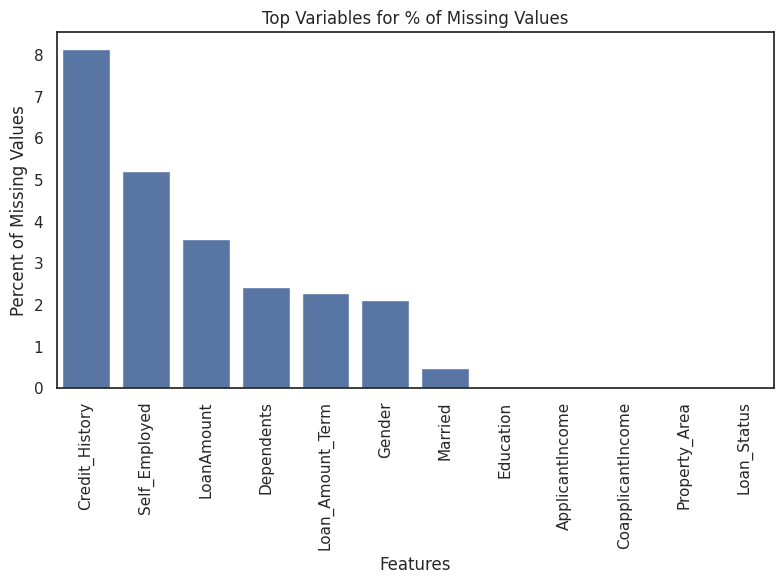

In [ ]:
fig, axs = plt.subplots(figsize=(8,6))
plt.xticks(rotation=90)
sns.barplot(x=dataset_na.index, y=dataset_na)
plt.xlabel('Features')
plt.ylabel('Percent of Missing Values')
plt.title('Top Variables for % of Missing Values')
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_valid, X_test = kNN_Imputation(X_train, X_valid, X_test, categorical_cols, numerical_cols)
y_train = y_train[X_train.index]
y_valid = y_valid[X_valid.index]
y_test = y_test[X_test.index]

Removing samples with missing values in multiple categorical features simultaneously ...
Training set samples removed: 7 (1.63%)
Validation set samples removed: 2 (2.17%)
Test set samples removed: 4 (4.30%)


### Data normalization

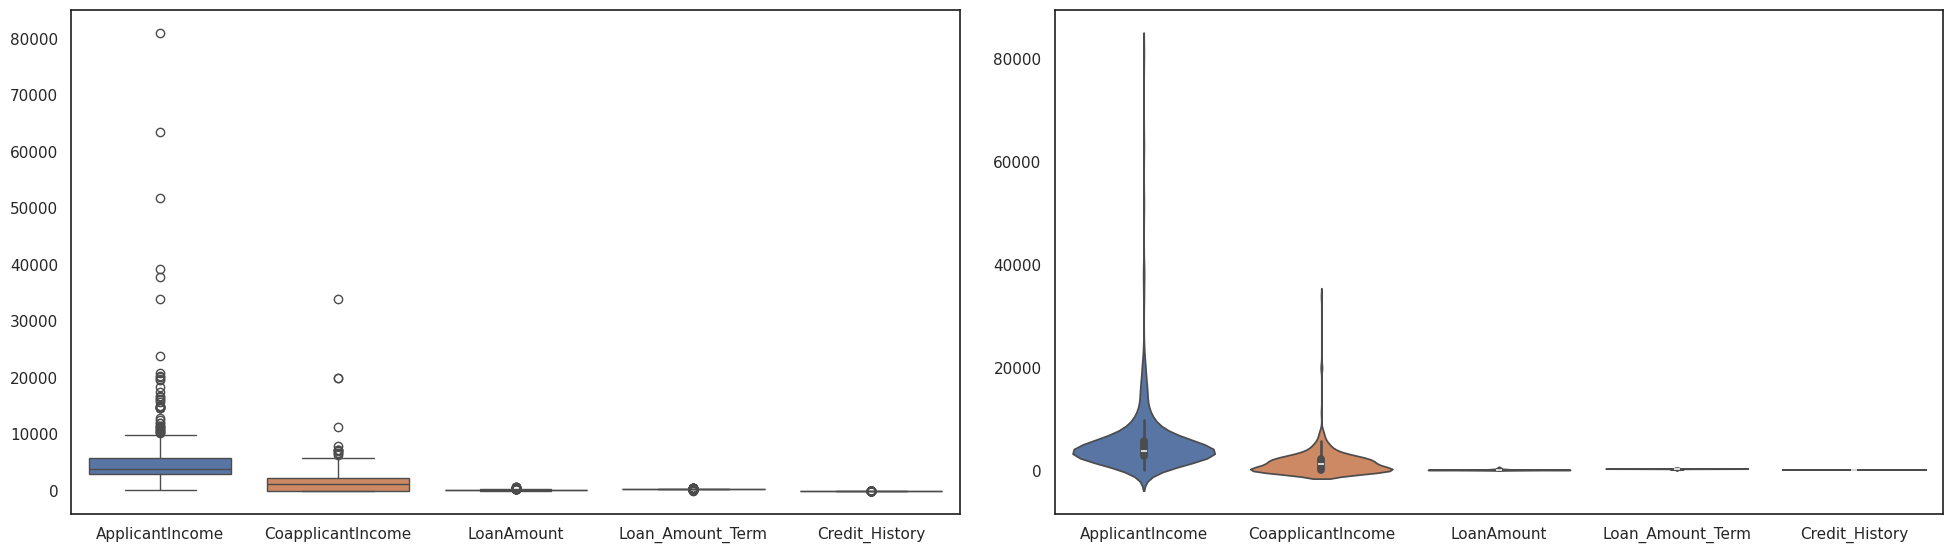

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### Standard Scaler
Standardize features by removing the mean and scaling to unit variance

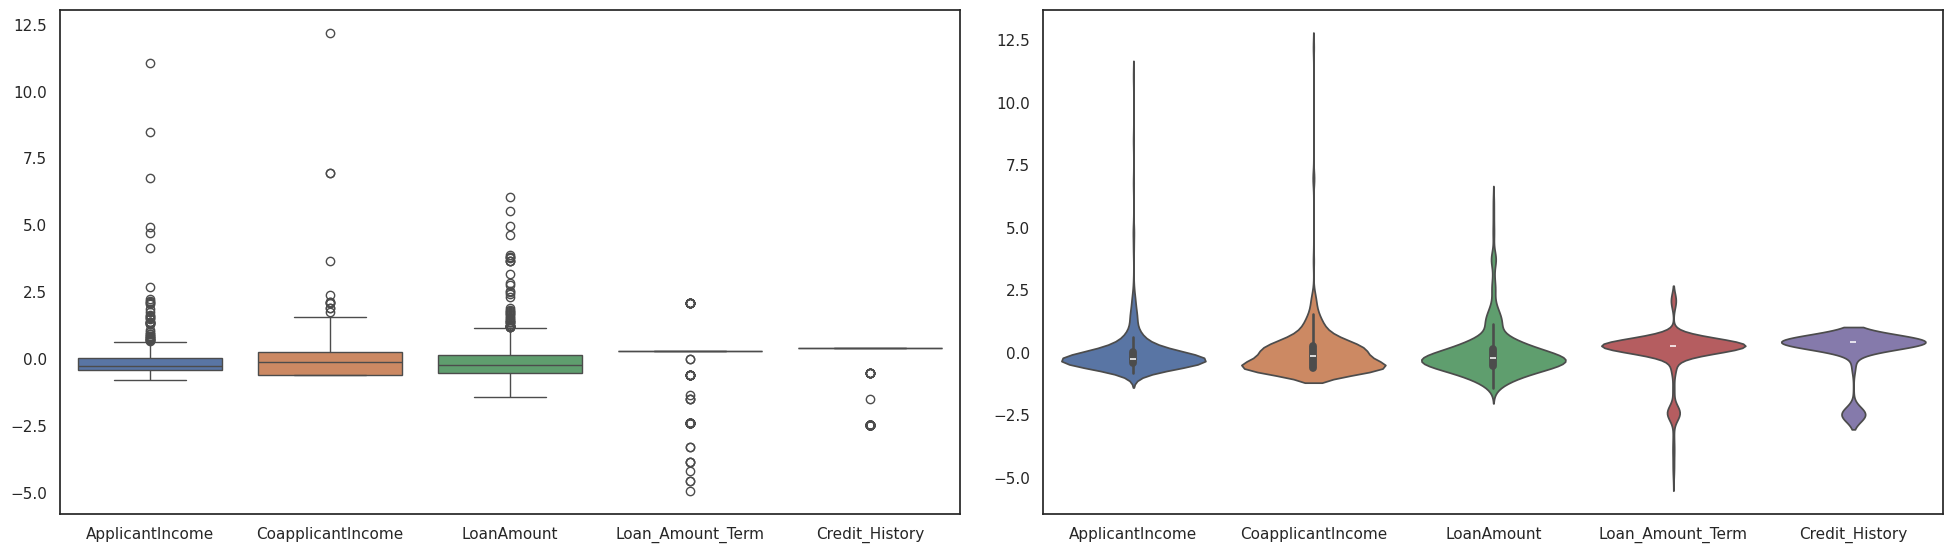

In [ ]:
X_train_scaled = X_train.copy()
scaler = StandardScaler().fit(X_train[numerical_cols])
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
sns.boxplot(data=X_train_scaled, ax=axs[0])
sns.violinplot(data=X_train_scaled, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### QuantileTransformer
StandardScaler is sensitive to outliers, as it relies on the mean and standard deviation for scaling, which can be significantly influenced by extreme values. In contrast, QuantileTransformer mitigates the impact of outliers by using quantiles information.
QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution within the range [0, 1], making outliers indistinguishable from inliers.

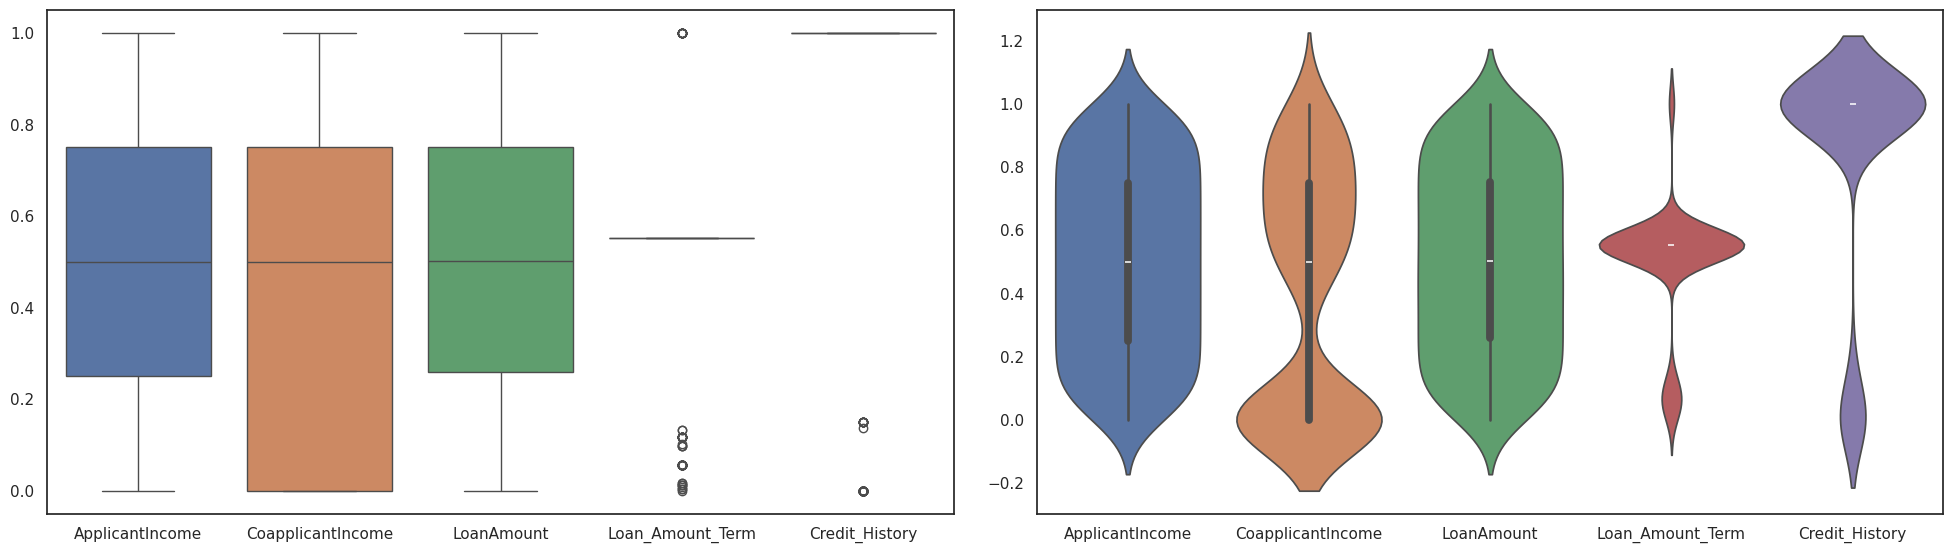

In [ ]:
scaler = QuantileTransformer(random_state=seed).fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])

X_valid[numerical_cols] = scaler.transform(X_valid[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

## HybridIG-CSO algorithm

### Attribute Ranking using IG technique
The information gain technique is a mathematical method used in feature selection for machine learning and data analysis. It measures the reduction in uncertainty, or entropy, about a target variable when a specific feature is known. This reduction in uncertainty is a key concept in information theory. Information gain is particularly useful to help select features that lead to the most informative splits in the data (Prasetiyowati et al., 2021).

In the initial stage, the Information Gain (IG) technique is employed to assess
attribute significance by ranking them according to their contribution to the desired outcome. To establish a suitable threshold, the standard deviation of IG values is calculated, a common practice for precise threshold determination (Roseline et al., 2022; Prasetiyowati et al., 2021). Attributes exceeding or meeting this threshold are retained, while those falling below it are discarded. This step ensures that only the most impactful attributes move forward.

Computes the entropy given a frequency count fc

In [4]:
def DistributionEntropy(fc) -> np.float64:
  d = fc/sum(fc)
  return sum([-x * np.log2(x) for x in d[d!=0]])

Distribution corresponding to each attribute value

In [5]:
def AttributeEntropy(attribute, target) -> np.float64:
  # Attribute entropy for numerical attributes
  if attribute.dtype != 'object':
    values = np.sort(attribute.unique())
    entropy_values = []
    for i, value in enumerate(values):
      left_mask = attribute<=value
      right_mask = ~left_mask
      entropy = left_mask.sum()/len(attribute) * DistributionEntropy(target[left_mask].value_counts())
      entropy += right_mask.sum()/len(attribute) * DistributionEntropy(target[right_mask].value_counts())
      entropy_values.append(entropy)
    return np.min(entropy_values)

  # Attribute entropy for categorical attributes
  weights = attribute.value_counts()/sum(attribute.value_counts())
  attribute_values = attribute.value_counts().index
  entropy = 0
  for i, value in enumerate(attribute_values):
    mask = attribute==value
    entropy += weights[i] * DistributionEntropy(target[mask].value_counts())
  return entropy

In [6]:
def InformationGain(attribute, target) -> np.float64:
  # original entropy
  original_entropy = DistributionEntropy(target.value_counts())
  # attribute entropy
  attribute_entropy = AttributeEntropy(attribute, target)
  # return the difference
  return original_entropy - attribute_entropy

In [ ]:
ig_values = {}
for col in X_train.columns:
  ig_values[col] = InformationGain(X_train[col], y_train)
  print(f"{col}: {ig_values[col]}")

# Compute the standard deviation of the Information Gain (IG) values
# threshold = np.std(list(ig_values.values()))
# Since the standard deviation threshold led to only one feature being selected by IG for this dataset, the threshold was slightly increased
threshold = 0.01
print(f"\nThreshold: {threshold}")
# Select attributes exceeding or meeting the threshold
ig_attributes = [col for col, ig in ig_values.items() if ig >= threshold]
print(f"Attributes exceeding or meeting the threshold: {ig_attributes}")

Gender: 0.00015048613797175037
Married: 0.0033662469933910533
Dependents: 0.005440008787871764
Education: 0.0036349854638298984
Self_Employed: 0.0014035990087347683
ApplicantIncome: 0.004196742161690414
CoapplicantIncome: 0.006169824637217047
LoanAmount: 0.008573586115043552
Loan_Amount_Term: 0.012545900615019367
Credit_History: 0.21466482223667516
Property_Area: 0.011133484195739118

Threshold: 0.01
Attributes exceeding or meeting the threshold: ['Loan_Amount_Term', 'Credit_History', 'Property_Area']


### Wrapper CSO algorithm with RWN learning
The wrapper-based technique employed here is CSO, chosen for its ability to explore the complex search space of potential feature subsets.
CSO is an algorithm rooted in the original PSO technique, devised to tackle the issue of premature convergence that often arises when applying PSO to complex search spaces containing numerous local optima (Cheng et al., 2015). Despite various proposed PSO modifications aiming to enhance its search capabilities in different problems, these often lead to increased complexity without effectively addressing the problem of premature convergence caused by gbest.
The distinctive advantage of CSO lies in its ability to counteract premature convergence by removing the influence of gbest and pbest associated with each particle.
CSO has demonstrated promising results in enhancing classification performance for various combinatorial problems.

#### Population generation
Define a Population by enumerating all possible subsets of top-ranked features (combinations without repetition).

In [7]:
def population_generator(ig_attributes, max_size=50) -> list:
  population = list(
      chain.from_iterable(
          combinations(ig_attributes, r) for r in range(1, len(ig_attributes)+1)
          ))
  if len(population) > max_size:
    # Randomly select particles from the population within the max size limit
    idxs = np.random.choice(len(population), max_size, False)
    return [population[i] for i in idxs]
  return population

#### Particles definition
The CSO particle is encoded as a real vector encompassing the subsequent components:

1.   a set of binary flags are included, signifying whether the corresponding features are chosen or not
2.   a set of binary flags is incorporated to dictate the number of neurons in the hidden layer of the RWN
3.   the RWN parameters, which encapsulate the values of input weights and hidden biases

In [8]:
def uniform_Xavier_initialization(input_size, output_size) -> np.array:
  limit = np.sqrt(6 / (input_size + output_size))
  return np.random.uniform(-limit, limit, (input_size, output_size))

def normal_Xavier_initialization(input_size, output_size) -> np.array:
  return np.random.randn(input_size, output_size) * np.sqrt(2 / (input_size + output_size))

def initialize_RWN_params(features, n_neurons) -> list:
  params = list()
  # Create a zero matrix of the max size
  max_n_neurons = 2**(len(features)) - 1
  W = np.zeros((len(features), max_n_neurons))
  # Initialize only the selected portion with random weights
  mask = features==1
  W[mask, :n_neurons] = uniform_Xavier_initialization(np.sum(features), n_neurons)
  # Create a zero vector of the max size
  b = np.zeros((max_n_neurons, 1))
  # Initialize only the selected portion with random weights
  b[:n_neurons] = np.random.randn(n_neurons, 1)
  params.append(W)
  params.append(b)
  return params

def create_particles(population, ig_attributes) -> list:
  particles = []
  for subset in population:
    features = {}
    for col in ig_attributes:
      features[col] = 1 if col in subset else 0
    n_neurons = ''.join(map(str, features.values()))
    params = initialize_RWN_params(
        np.array(list(features.values())), int(n_neurons, 2))
    particles.append({
        'features':features, 'n_neurons':n_neurons, 'params':params})
  return particles

#### Random Weight Network
The fundamental architecture of the RWN network follows a completely connected architecture with only one hidden layer. In contrast to conventional gradient-descent techniques that require the configuration of various parameters such as learning rates and the number of training epochs, RWN simplifies this process by focusing on just one parameter: the count of hidden
neurons.

In [9]:
def prepare_data(particle, X, y=None) -> tuple:
  # Retrieve the names of the selected features
  features = [key for key, value in particle['features'].items() if value == 1]
  # Create subset of the dataset based on the selected features
  X_subset = X[features].copy()
  # Retrieve the categorical features
  categorical_cols = X_subset.select_dtypes(
      include=['object']).columns.tolist()
  # Label encoding of categorical features
  encoder = LabelEncoder()
  for col in categorical_cols:
    X_subset[col] = encoder.fit_transform(X_subset[col])
  if y is not None:
    y = encoder.fit_transform(y)
  return X_subset, y

def sigmoid(x) -> np.float64:
  return 1 / (1 + np.exp(-x))

def compute_H(dataset, particle) -> np.array:
  n_neurons = int(particle['n_neurons'], 2)
  params = particle['params']
  # Select only the weights and biases corresponding to the selected features
  mask = np.array(list(particle['features'].values()))==1
  weights = params[0][mask, :n_neurons]
  bias = params[1][:n_neurons].flatten()
  H = sigmoid(dataset @ weights + bias)
  return np.array(H)

def RWN_model(particle, X, y) -> np.array:
  X_train, y_train = prepare_data(particle, X, y)
  # Calculate the hidden layer output matrix H
  H = compute_H(X_train, particle)
  # Output weights β determined using the Moore-Penrose generalized inverse
  return np.linalg.pinv(H) @ y_train

### Fitness Calculation
The fitness of each particle is
calculated, representing its ability to contribute effectively to the desired outcomes. This fitness calculation guides
the subsequent steps towards optimal configuration.

The fitness function is computed as follows:

\begin{equation}
Fit = \alpha CLErr + \beta \frac{ft}{FT} + \gamma \frac{hd}{HD}
\end{equation}

where $CLErr$ represents the error rate in classifying the RWN network, $ft$ indicates the number of features selected, $FT$ represents the overall count of features in the dataset, $hd$ denotes the count of hidden neurons set by the optimizer and $HD$ is the maximum allowable number of neurons in the RWN. The parameters $\alpha$, $\beta$ and $\gamma$ manage the impact of weights, aiming to enhance the reduction rate of features, curtail RWN complexity, and diminish the quantity of chosen features.

In [10]:
def compute_error_rate(pred, y_true) -> np.float64:
  return np.mean(pred != y_true)

def compute_pred(particle, X_train, y_train, X, threshold) -> np.float64:
  # Train the RWN model
  B = RWN_model(particle, X_train, y_train)
  X_test, _ = prepare_data(particle, X)
  # Calculate the hidden layer output matrix H on validation/test set
  H_test = compute_H(X_test, particle)
  # Compute predictions
  pred = H_test @ B
  return (pred > threshold).astype(int)

def compute_fitness(particle, X_train, y_train, X, y, dataset_features, alpha, beta, gamma, threshold) -> list:
  # Compute the classification error rate
  pred = compute_pred(particle, X_train, y_train, X, threshold)
  error_rate = compute_error_rate(pred, y)
  # Number of features identified
  ft = np.sum(list(particle['features'].values()))
  # Count of hidden neurons set by the optimizer
  hd = int(particle['n_neurons'], 2)
  # Maximum allowable number of neurons in the RWN
  HD = 2**(len(particle['features'])+1) - 1
  # Compute fitness
  return alpha * error_rate + beta * (ft / dataset_features) + gamma * (hd / HD)

### CSO Particle Initialization and Competition
The CSO Randomly initializes the number of individuals for each population, where candidate feature subsets are encoded as particles. The population is divided into two equal parts, each comprising k/2 individuals. The ensuing pairwise competition determines winners and losers among particles.
Winners advance to the next generation, while losers undergo updates before moved to the next generation. The subsequent stage entails training diverse RWNs using each particle, followed by the computation of the fitness value for each feature subset. Aims to refine the particle population iteratively.

In [11]:
def initialize_population(ig_attributes) -> list:
  # Initialize population
  population = population_generator(ig_attributes)
  # Initialize particles
  particles = create_particles(population, ig_attributes)
  return particles

def compute_mean_particle(particles) -> tuple:
  # Compute the majority vote for selected features
  data = np.array([list(particle['features'].values()) for particle in particles])
  # Compare counts to half the number of rows to determine majority
  majority_features = (np.sum(data, axis=0) > data.shape[0] / 2).astype(int)
  # Compute the mean of the parameters for the particles
  mean_weights = np.mean([particle['params'][0] for particle in particles], axis=0)
  mean_biases = np.mean([particle['params'][1] for particle in particles], axis=0)
  mean_params = [mean_weights, mean_biases]
  return majority_features, mean_params

def update_loser(ig_attributes, velocity, winner, loser, majority_features, mean_params, phi, threshold) -> tuple:
  # Matrix of vectors with randomly generated numbers sampled from the range [0,1)
  R = np.random.rand(3)
  # Compute the velocity update for feature selection in the loser particle
  X_wi = np.array(list(winner['features'].values()))
  X_li = np.array(list(loser['features'].values()))
  vel_feature = R[0]*velocity[0] + R[1]*(X_wi - X_li) + R[2]*phi*(majority_features-X_li)
  X_li_updated = (sigmoid(X_li + vel_feature) > threshold).astype(int)
  features = {}
  for i, col in enumerate(ig_attributes):
    features[col] = X_li_updated[i]
  n_neurons = ''.join(map(str, features.values()))
  # Compute the velocity update for the weights in the RWN configuration
  X_wi = winner['params'][0]
  X_li = loser['params'][0]
  vel_weights = R[0]*velocity[1] + R[1]*(X_wi - X_li) + R[2]*phi*(mean_params[0]-X_li)
  weights = X_li + vel_weights
  # Compute the velocity update for the biases in the RWN configuration
  X_wi = winner['params'][1]
  X_li = loser['params'][1]
  vel_biases = R[0]*velocity[2] + R[1]*(X_wi - X_li) + R[2]*phi*(mean_params[1]-X_li)
  biases = X_li + vel_biases
  particle = {'features':features, 'n_neurons':n_neurons, 'params':[weights, biases]}
  return particle, [vel_feature, vel_weights, vel_biases]

def evaluate_particles(ig_attributes, particle_1, particle_2, velocity_1, velocity_2, X_train, y_train, X_valid, y_valid, dataset_features, alpha, beta, gamma, phi, majority_features, mean_params, threshold):
  # Compute the fitness for both particles
  fitness_curr = compute_fitness(particle_1, X_train, y_train, X_valid, y_valid, dataset_features, alpha, beta, gamma, threshold)
  fitness_next = compute_fitness(particle_2, X_train, y_train, X_valid, y_valid, dataset_features, alpha, beta, gamma, threshold)
  # Compare fitness values to determine the winner and loser
  if fitness_curr >= fitness_next:
    # The first particle wins, update the second particle
    loser_particle, loser_vel = update_loser(ig_attributes, velocity_2, particle_1, particle_2, majority_features, mean_params, phi, threshold)
    return [particle_1, loser_particle], [velocity_1, loser_vel]
  else:
    # The second particle wins, update the first particle
    loser_particle, loser_vel = update_loser(ig_attributes, velocity_1, particle_2, particle_1, majority_features, mean_params, phi, threshold)
    return [particle_2, loser_particle], [velocity_2, loser_vel]

def competition(ig_attributes, particles, velocities, X_train, y_train, X_valid, y_valid, dataset_features, alpha, beta, gamma, phi, threshold) -> tuple:
  # Randomly shuffle the particles and velocities
  particles, velocities = shuffle(particles, velocities)
  majority_features, mean_params = compute_mean_particle(particles)
  next_gen_particles = []
  next_gen_vel = []
  # Execute the evaluation and update of particles in parallel
  results = Parallel(n_jobs=-1)(
      delayed(evaluate_particles)(
          ig_attributes,
          particles[i], particles[i+1], velocities[i], velocities[i+1],
          X_train, y_train, X_valid, y_valid,
          dataset_features, alpha, beta, gamma, phi,
          majority_features, mean_params,
          threshold
        ) for i in range(0, len(particles)-1, 2))
  # Extract the results
  for result in results:
    next_gen_particles.extend(result[0])
    next_gen_vel.extend(result[1])
  # If there is an odd number of particles, add the last one to the winners list
  if len(particles) % 2 != 0:
    next_gen_particles.append(particles[-1])
    next_gen_vel.append(velocities[-1])
  return next_gen_particles, next_gen_vel

### Iterative Refinement
The methodology persists iteratively until a predefined maximum iteration count is reached.
Throughout this process, the wrapper CSO algorithm continues its pursuit of the best feature subset and corresponding RWN configuration. The culmination of these efforts aims to achieve significantly enhanced prediction performance.

In [12]:
def train_model(ig_attributes, X_train, y_train, X_valid, y_valid, n_features, alpha, beta, gamma, phi, threshold, max_iter=100) -> list:
  particles = initialize_population(ig_attributes)
  velocities = [
      [
      np.random.randn(len(ig_attributes)),
      np.random.randn(*particle['params'][0].shape),
      np.random.randn(*particle['params'][1].shape)
      ] for particle in particles
  ]
  for i in range(max_iter):
    particles, velocities = competition(ig_attributes, particles, velocities, X_train, y_train, X_valid, y_valid, n_features, alpha, beta, gamma, phi, threshold)
  return particles

### Testing

In [13]:
def compute_metrics(pred, y_true) -> list:
  tn, fn, fp, tp = confusion_matrix(pred, y_true).flatten()
  precision, recall, fscore = np.array(precision_recall_fscore_support(pred, y_true, zero_division=0))[:3, 1]
  accuracy = accuracy_score(pred, y_true)
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  gmean = np.sqrt(sensitivity * specificity)
  auc = roc_auc_score(y_true, pred)
  metrics = [
      accuracy,
      precision,
      recall,
      fscore,
      sensitivity,
      specificity,
      gmean,
      auc
  ]
  return metrics


def print_metrics(metrics) -> None:
  metric_names = [
      'Accuracy',
      'Precision',
      'Recall',
      'F1-Score',
      'Sensitivity',
      'Specificity',
      'G-Mean',
      'AUC']
  print("=" * 50)
  print(f"{'Metric':<20} | {'Value':>10}")
  print("-" * 50)
  for name, value in zip(metric_names, metrics):
    print(f"{name:<20} | {value:>10.4f}")
  print("=" * 50)


def test_model(ig_attributes, X_train, y_train, X, y, dataset_features, alpha, beta, gamma, phi, threshold, max_iter=100) -> tuple:
  particles = np.array(train_model(ig_attributes, X_train, y_train, X, y, dataset_features, alpha, beta, gamma, phi, threshold, max_iter))
  y_test = LabelEncoder().fit_transform(y)
  metrics = np.array([
      compute_metrics(
          compute_pred(particle, X_train, y_train, X, threshold),
          y_test
      ) for particle in particles])
  # Select the particle with the highest accuracy score
  best_score_idx = np.argmax(metrics[:, 0])
  best_particle = particles[best_score_idx]
  best_scores = metrics[best_score_idx]
  return best_particle, best_scores

In [14]:
def HIGCSO_compute_scores_fold(ig_attributes, X_train, y_train, train_idx, val_idx, dataset_features, alpha, beta, gamma, phi, threshold, max_iter) -> np.float64:
  X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_valid_fold = y_train[train_idx], y_train[val_idx]
  # Compute scores for the current fold
  _, scores = test_model(
      ig_attributes,
      X_train_fold, y_train_fold,
      X_valid_fold, y_valid_fold,
      dataset_features, alpha, beta, gamma, phi,
      threshold, max_iter)
  return scores

def HIGCSO_kFoldCV(kf, ig_attributes, X_train, y_train, dataset_features, alpha, beta, gamma, phi, threshold, max_iter) -> np.float64:
  y = LabelEncoder().fit_transform(y_train)
  # Parallelized KFold Cross-validation
  fold_scores = Parallel(n_jobs=-1)(
      delayed(HIGCSO_compute_scores_fold)(
          ig_attributes,
          X_train, y,
          train_idx, val_idx,
          dataset_features,
          alpha, beta, gamma, phi,
          threshold,
          max_iter) for train_idx, val_idx in kf.split(X_train))
  # Average scores across all folds
  return np.mean(fold_scores, axis=0)


def RWN_compute_scores_fold(particle, X_train, y_train, train_idx, val_idx, threshold) -> np.float64:
  X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_valid_fold = y_train[train_idx], y_train[val_idx]
  B = RWN_model(particle, X_train_fold, y_train_fold)
  pred = compute_pred(particle, X_train_fold, y_train_fold, X_valid_fold, threshold)
  # Compute scores for the current fold
  scores = compute_metrics(pred, y_valid_fold)
  return scores

def RWN_kFoldCV(kf, particle, X_train, y_train, threshold) -> np.float64:
  y = LabelEncoder().fit_transform(y_train)
  # Parallelized KFold Cross-validation
  fold_scores = Parallel(n_jobs=-1)(
      delayed(RWN_compute_scores_fold)(
          particle,
          X_train, y,
          train_idx, val_idx,
          threshold) for train_idx, val_idx in kf.split(X_train))
  # Average scores across all folds
  return np.mean(fold_scores, axis=0)


def clf_compute_scores_fold(clf, X_train, y_train, train_idx, val_idx) -> np.float64:
  X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_valid_fold = y_train[train_idx], y_train[val_idx]
  clf.fit(X_train_fold, y_train_fold)
  pred = clf.predict(X_valid_fold)
  # Compute scores for the current fold
  scores = compute_metrics(pred, y_valid_fold)
  return scores

def clf_kFoldCV(clf, kf, X_train, y_train) -> np.float64:
  y = LabelEncoder().fit_transform(y_train)
  # Parallelized KFold Cross-validation
  fold_scores = Parallel(n_jobs=-1)(
      delayed(clf_compute_scores_fold)(
          clf,
          X_train, y,
          train_idx, val_idx) for train_idx, val_idx in kf.split(X_train))
  # Average scores across all folds
  return np.mean(fold_scores, axis=0)

#### Hyperparameter tuning
Optimize the hyperparameters $\alpha$, $\beta$, $\gamma$ and $\varphi$ through a 10-fold cross-validation approach, by determining the combination that yields the highest average score over the 10 folds.

In [15]:
def perform_tuning(kf, param_grid, best_score, best_params, ig_attributes, X, y, dataset_features, categorical_cols, max_iter, threshold) -> tuple:
  # Iterate over all combinations of alpha
  avg_scores = np.array(
      Parallel(n_jobs=-1)(delayed(HIGCSO_kFoldCV)(
          kf, ig_attributes,
          X_train, y_train,
          dataset_features,
          alpha, beta, gamma, phi,
          threshold,
          max_iter) for alpha, beta, gamma, phi in tqdm(
              param_grid, total=len(param_grid))))
  # Identify the hyperparameters combination yielding the highest accuracy score
  if best_score < np.max(avg_scores[:, 0]):
    best_score = np.max(avg_scores[:, 0])
    best_params = param_grid[np.argmax(avg_scores[:, 0])]
  return best_score, best_params

def hyperparameter_tuning(ig_attributes, X, y, dataset_features, categorical_cols, max_iter, threshold) -> tuple:
  # SMOTE
  X_train, y_train = perform_SMOTE(X, y, categorical_cols)
  values = [1e-3, 0.1, 1, 10, 100]
  # Provides train/test indices to split data in train/test sets
  kf = KFold(n_splits=10, shuffle=True, random_state=seed)
  # Define alpha search space
  param_grid = [(alpha, 0.5, 0.5, 0.5) for alpha in values]
  print('Tuning alpha ...')
  best_score, best_params = perform_tuning(
      kf, param_grid, -np.inf, None,
      ig_attributes,
      X, y, dataset_features, categorical_cols, max_iter, threshold)
  # Define beta search space
  param_grid = [(best_params[0], beta, 0.5, 0.5) for beta in values]
  print('Tuning beta ...')
  best_score, best_params = perform_tuning(
      kf, param_grid, best_score, best_params,
      ig_attributes,
      X, y, dataset_features, categorical_cols, max_iter, threshold)
  # Define gamma search space
  param_grid = [(best_params[0], best_params[1], gamma, 0.5) for gamma in values]
  print('Tuning gamma ...')
  best_score, best_params = perform_tuning(
      kf, param_grid, best_score, best_params,
      ig_attributes,
      X, y, dataset_features, categorical_cols, max_iter, threshold)
  # Define phi search space
  param_grid = [(best_params[0], best_params[1], best_params[2], phi) for phi in values]
  print('Tuning phi ...')
  best_score, best_params = perform_tuning(
      kf, param_grid, best_score, best_params,
      ig_attributes,
      X, y, dataset_features, categorical_cols, max_iter, threshold)
  print("Best parameters: ", best_params)
  print("Best fitness score: ", best_score)
  return best_params

In [ ]:
# The threshold for the sigmoid activation function (classifying predictions as positive if they exceed the threshold and negative otherwise)
threshold = 0.5

# Hyperparameter tuning
alpha, beta, gamma, phi = hyperparameter_tuning(
    ig_attributes,
    pd.concat([X_train, X_valid, X_test]), pd.concat([y_train, y_valid, y_test]),
    n_features, categorical_cols, 20, threshold)

Tuning alpha ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning beta ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning gamma ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning phi ...


  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters:  (0.001, 1, 0.001, 0.5)
Best fitness score:  0.8101328903654486


## Experiment I: Comparisons performance between HybridIG-CSO, RWN with filter approach, and RWN with CSO
In this experiment, the HybridIG-CSO method was evaluated by comparing it with three distinct techniques: the classical RWN, RWN with a filter-based approach (IG-RWN) and manually tuned CSO-RWN. The performance of the HybridIG-CSO method was assessed against the other approaches using six different metrics: Accuracy, Precision, Recall, AUC, F1 and G-mean.

In [ ]:
def experiment1(ig_attributes, X_train, y_train, X_test, y_test, categorical_cols, dataset_features, alpha, beta, gamma, phi, threshold, max_iter=100, kf=None) -> tuple:
  # classical RWN
  particle_RWN = create_particles([X_train.columns], X_train.columns)[0]
  # IG-RWN
  particle_IGRWN = create_particles([ig_attributes], ig_attributes)[0]
  # Determine whether to perform testing with 10-Fold Cross-Validation or a separate test set
  if kf is not None:
    X, y = perform_SMOTE(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), categorical_cols)
    # HybridIG-CSO
    HIGCSO_best_scores = HIGCSO_kFoldCV(kf, ig_attributes, X, y, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # classical RWN
    RWN_scores = RWN_kFoldCV(kf, particle_RWN, X, y, threshold)
    # IG-RWN
    IGRWN_scores = RWN_kFoldCV(kf, particle_IGRWN, X, y, threshold)
    # manually tuned CSO-RWN
    CSORWN_best_scores = HIGCSO_kFoldCV(kf, X.columns, X, y, dataset_features, alpha, beta, gamma, phi, threshold, 1)
  else:
    X, y = perform_SMOTE(X_train, y_train, categorical_cols)
    # HybridIG-CSO
    _, HIGCSO_best_scores = test_model(ig_attributes, X, y, X_test, y_test, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # classical RWN
    B = RWN_model(particle_RWN, X, y)
    y_true = LabelEncoder().fit_transform(y_test)
    pred = compute_pred(particle_RWN, X, y, X_test, threshold)
    RWN_scores = compute_metrics(pred, y_true)
    # IG-RWN
    B = RWN_model(particle_IGRWN, X, y)
    pred = compute_pred(particle_IGRWN, X, y, X_test, threshold)
    IGRWN_scores = compute_metrics(pred, y_true)
    # manually tuned CSO-RWN
    _, CSORWN_best_scores = test_model(X.columns, X, y, X_test, y_test, dataset_features, alpha, beta, gamma, phi, threshold, 1)
  print('\033[34mHybridIG-CSO \033[0m')
  print_metrics(HIGCSO_best_scores)
  print('\033[34m\nClassical RWN \033[0m')
  print_metrics(RWN_scores)
  print('\033[34m\nIG-RWN \033[0m')
  print_metrics(IGRWN_scores)
  print('\033[34m\nManually tuned CSO-RWN \033[0m')
  print_metrics(CSORWN_best_scores)
  return HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7528
Precision            |     0.9623
Recall               |     0.7183
F1-Score             |     0.8226
Sensitivity          |     0.9623
Specificity          |     0.4444
G-Mean               |     0.6540
AUC                  |     0.7034

Classical RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.5393
Precision            |     0.5094
Recall               |     0.6429
F1-Score             |     0.5684
Sensitivity          |     0.5094
Specificity          |     0.5833
G-Mean               |     0.5451
AUC                  |     0.5464

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7528
Precision            |     0.9623
Recall               |     0.7183
F1-Score             |     0.8226
Sensitivity          |    

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7018
Precision            |     0.8960
Recall               |     0.6450
F1-Score             |     0.7474
Sensitivity          |     0.8960
Specificity          |     0.5086
G-Mean               |     0.6713
AUC                  |     0.7023

Classical RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.4904
Precision            |     0.4984
Recall               |     0.4933
F1-Score             |     0.4915
Sensitivity          |     0.4984
Specificity          |     0.4839
G-Mean               |     0.4857
AUC                  |     0.4912

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7332
Precision            |     0.9540
Recall               |     0.6633
F1-Score             |     0.7809
Sensitivity          |    

## Experiment II: Comparison with other classifiers
In this experimental evaluation, the effectiveness of the HybridIG-CSO is assessed in the context of fraud classification, by comparing its performance against other widely employed algorithms typically used as induction techniques in feature selection wrapper-based methods, namely Naïve Bayes (NB), Random Forest (RF) and Support Vector Machine (SVM).

In [ ]:
def experiment2(ig_attributes, X_train, y_train, X_test, y_test, categorical_cols, dataset_features, alpha, beta, gamma, phi, threshold, max_iter=100, kf=None) -> tuple:
  for df in [X_train, X_test]:
    # Label encoding of categorical features
    encoders = {}
    # Encode categorical features with value between 0 and n_classes-1
    for col in categorical_cols:
      encoder = LabelEncoder()
      df[col] = encoder.fit_transform(df[col])
      # Store the fitted LabelEncoders for each categorical column
      encoders[col] = encoder
  # Naïve Bayes (NB)
  nb = GaussianNB()
  # Random Forest (RF)
  rf = RandomForestClassifier(random_state=seed)
  # Support Vector Machine (SVM)
  svc = SVC(random_state=seed, gamma='auto')
  # Determine whether to perform testing with 10-Fold Cross-Validation or a separate test set
  if kf is not None:
    X, y = perform_SMOTE(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), categorical_cols)
    # HybridIG-CSO
    HIGCSO_best_scores = HIGCSO_kFoldCV(kf, ig_attributes, X, y, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # Naïve Bayes (NB)
    NB_best_scores = clf_kFoldCV(nb, kf, X, y)
    # Random Forest (RF)
    RF_best_scores = clf_kFoldCV(rf, kf, X, y)
    # Support Vector Machine (SVM)
    SVM_best_scores = clf_kFoldCV(svc, kf, X, y)
  else:
    X, y = perform_SMOTE(X_train, y_train, categorical_cols)
    # HybridIG-CSO
    _, HIGCSO_best_scores = test_model(ig_attributes, X, y, X_test, y_test, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # Test set label encoding
    y = LabelEncoder().fit_transform(y)
    y_true = LabelEncoder().fit_transform(y_test)
    # Naïve Bayes (NB)
    nb.fit(X, y)
    pred = nb.predict(X_test)
    NB_best_scores = compute_metrics(pred, y_true)
    # Random Forest (RF)
    rf.fit(X, y)
    pred = rf.predict(X_test)
    RF_best_scores = compute_metrics(pred, y_true)
    # Support Vector Machine (SVM)
    svc.fit(X, y)
    pred = svc.predict(X_test)
    SVM_best_scores = compute_metrics(pred, y_true)
  print('\033[34mHybridIG-CSO \033[0m')
  print_metrics(HIGCSO_best_scores)
  print('\033[34m\nNaïve Bayes (NB) \033[0m')
  print_metrics(NB_best_scores)
  print('\033[34m\nRandom Forest (RF) \033[0m')
  print_metrics(RF_best_scores)
  print('\033[34m\nSupport Vector Machine (SVM) \033[0m')
  print_metrics(SVM_best_scores)
  for df in [X_train, X_test]:
    # Transform the encoded categorical features back
    for col in categorical_cols:
      df[col] = encoders[col].inverse_transform(df[col].astype(int))
  return HIGCSO_best_scores, NB_best_scores, RF_best_scores, SVM_best_scores

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, NB_best_scores, RF_best_scores, SVM_best_scores = experiment2(
    ig_attributes,
    pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
    X_test, y_test,
    categorical_cols, n_features,
    alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7528
Precision            |     0.9623
Recall               |     0.7183
F1-Score             |     0.8226
Sensitivity          |     0.9623
Specificity          |     0.4444
G-Mean               |     0.6540
AUC                  |     0.7034

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7528
Precision            |     0.9623
Recall               |     0.7183
F1-Score             |     0.8226
Sensitivity          |     0.9623
Specificity          |     0.4444
G-Mean               |     0.6540
AUC                  |     0.7034

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7528
Precision            |     0.9057
Recall               |     0.7385
F1-Score             |     0.8136
Sensitivity

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment2(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7018
Precision            |     0.8960
Recall               |     0.6450
F1-Score             |     0.7474
Sensitivity          |     0.8960
Specificity          |     0.5086
G-Mean               |     0.6713
AUC                  |     0.7023

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7248
Precision            |     0.9492
Recall               |     0.6566
F1-Score             |     0.7746
Sensitivity          |     0.9492
Specificity          |     0.5041
G-Mean               |     0.6907
AUC                  |     0.7267

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.8044
Precision            |     0.8334
Recall               |     0.7908
F1-Score             |     0.8106
Sensitivity

In [ ]:
del dataset, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, categorical_cols, kf, ig_values, ig_attributes, alpha, beta, gamma, phi, threshold

# Dataset 2 - Credit card csv present
https://github.com/gksj7/creditcardcsvpresent/blob/main/creditcardcsvpresent.csv

## Dataset Analysis

In [ ]:
dataset = pd.read_csv(path + 'creditcardcsvpresent.csv')

In [ ]:
dataset

Merchant_id  Transaction date  Average Amount/transaction/day  \
0      3160040998               NaN                           100.0   
1      3160040998               NaN                           100.0   
2      3160041896               NaN                           185.5   
3      3160141996               NaN                           185.5   
4      3160241992               NaN                           500.0   
...           ...               ...                             ...   
3070   6661273532               NaN                           500.0   
3071   6661273532               NaN                           800.0   
3072   6661273533               NaN                           800.0   
3073   6661273532               NaN                          1500.0   
3074   6661273533               NaN                          1500.0   

      Transaction_amount Is declined  Total Number of declines/day  \
0                 3000.0           N                             5   
1                 4300.0           N                             5   
2                 4823.0           Y                             5   
3                 5008.5           Y                             8   
4                26000.0           N                             0   
...                  ...         ...                           ...   
3070             11000.0           Y                             0   
3071                 0.0           Y                             0   
3072             20800.0           Y                             0   
3073             12000.0           Y                             0   
3074             36000.0           Y                             0   

     isForeignTransaction isHighRiskCountry  Daily_chargeback_avg_amt  \
0                       Y                 Y                         0   
1                       Y                 Y                         0   
2                       N                 N                         0   
3                       N                 N                         0   
4                       Y                 Y                       800   
...                   ...               ...                       ...   
3070                    N                 N                       754   
3071                    N                 N                       754   
3072                    N                 N                       754   
3073                    Y                 Y                       754   
3074                    Y                 Y                       754   

      6_month_avg_chbk_amt  6-month_chbk_freq isFradulent  
0                      0.0                  0           Y  
1                      0.0                  0           Y  
2                      0.0                  0           Y  
3                      0.0                  0           Y  
4                    677.2                  6           Y  
...                    ...                ...         ...  
3070                 585.0                  7           N  
3071                 585.0                  7           N  
3072                 585.0                  7           N  
3073                 585.0                  7           N  
3074                 585.0                  7           N  

[3075 rows x 12 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

In [ ]:
dataset.describe()

Merchant_id  Transaction date  Average Amount/transaction/day  \
count  3.075000e+03               0.0                     3075.000000   
mean   5.026634e+09               NaN                      515.026556   
std    9.870778e+08               NaN                      291.906978   
min    3.160041e+09               NaN                        4.011527   
25%    4.170814e+09               NaN                      269.788047   
50%    5.025578e+09               NaN                      502.549575   
75%    5.889625e+09               NaN                      765.272803   
max    6.665906e+09               NaN                     2000.000000   

       Transaction_amount  Total Number of declines/day  \
count         3075.000000                   3075.000000   
mean          9876.399210                      0.957398   
std          10135.331016                      2.192391   
min              0.000000                      0.000000   
25%           2408.781147                      0.000000   
50%           6698.891856                      0.000000   
75%          14422.568935                      0.000000   
max         108000.000000                     20.000000   

       Daily_chargeback_avg_amt  6_month_avg_chbk_amt  6-month_chbk_freq  
count               3075.000000           3075.000000        3075.000000  
mean                  55.737561             40.022407           0.391870  
std                  206.634779            155.968840           1.548479  
min                    0.000000              0.000000           0.000000  
25%                    0.000000              0.000000           0.000000  
50%                    0.000000              0.000000           0.000000  
75%                    0.000000              0.000000           0.000000  
max                  998.000000            998.000000           9.000000

In [ ]:
# Remove Transaction date column as all its values are null
dataset.drop('Transaction date', axis=1, inplace=True)
dataset.info()

# Retrieve the categorical columns from the dataframe
categorical_cols = dataset.iloc[:, :-1].select_dtypes(include=['object']).columns.tolist()
# Retrieve the numerical columns from the dataframe
numerical_cols = dataset.iloc[:, :-1].columns.difference(categorical_cols).tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Average Amount/transaction/day  3075 non-null   float64
 2   Transaction_amount              3075 non-null   float64
 3   Is declined                     3075 non-null   object 
 4   Total Number of declines/day    3075 non-null   int64  
 5   isForeignTransaction            3075 non-null   object 
 6   isHighRiskCountry               3075 non-null   object 
 7   Daily_chargeback_avg_amt        3075 non-null   int64  
 8   6_month_avg_chbk_amt            3075 non-null   float64
 9   6-month_chbk_freq               3075 non-null   int64  
 10  isFradulent                     3075 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 264.4+ KB


In [ ]:
n_features = len(dataset.columns) - 1

print(f"# samples = {len(dataset)}")
print(f"# features = {n_features}")
print(f"target: {dataset.columns[-1]}")

# samples = 3075
# features = 10
target: isFradulent


### Skewness

Skewness is a statistical measure that quantifies the asymmetry of the distribution of values in a dataset. It indicates whether the data points are skewed to the left (negative skew) or the right (positive skew) relative to the mean.

*   **Positive Skewness (Right Skew)**: the majority of data points are concentrated on the left side of the distribution, with a few extreme values on the right side.
<center> Mean > Median > Mode </center>

*   **Negative Skewness (Left Skew)**: most of the data points are concentrated on the right side of the distribution, while a few extreme values on the left side.
<center> Mean < Median < Mode </center>

*   **Zero Skewness (Symmetrical Distribution)**: perfectly symmetrical distribution, where the mean, median, and mode are equal. In such a distribution, the data points are evenly distributed around the central point.

In [ ]:
# Compute the skewness only for non missing variables
skewed_feats = dataset[numerical_cols].apply(lambda x: skew(x.dropna()))
skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
skewness

Variable  Skewness
0               6-month_chbk_freq  4.047330
1            6_month_avg_chbk_amt  4.035452
2  Average Amount/transaction/day  0.178535
3        Daily_chargeback_avg_amt  3.563309
4                     Merchant_id -0.015344
5    Total Number of declines/day  2.693559
6              Transaction_amount  2.105207

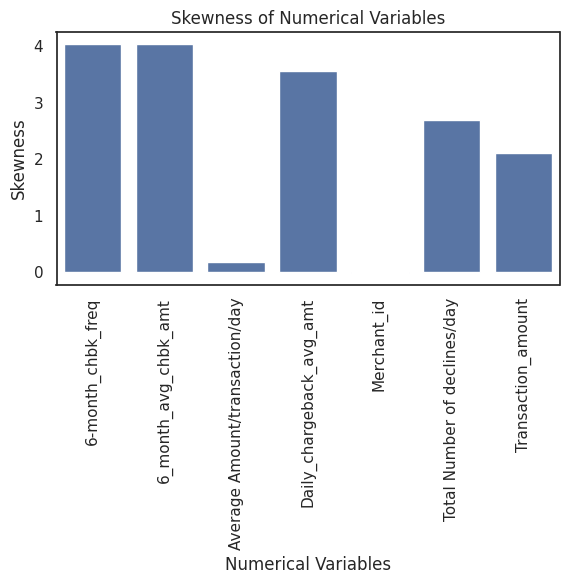

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.xticks(rotation=90)
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.xlabel('Numerical Variables')
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Variables')
plt.tight_layout()
plt.show()

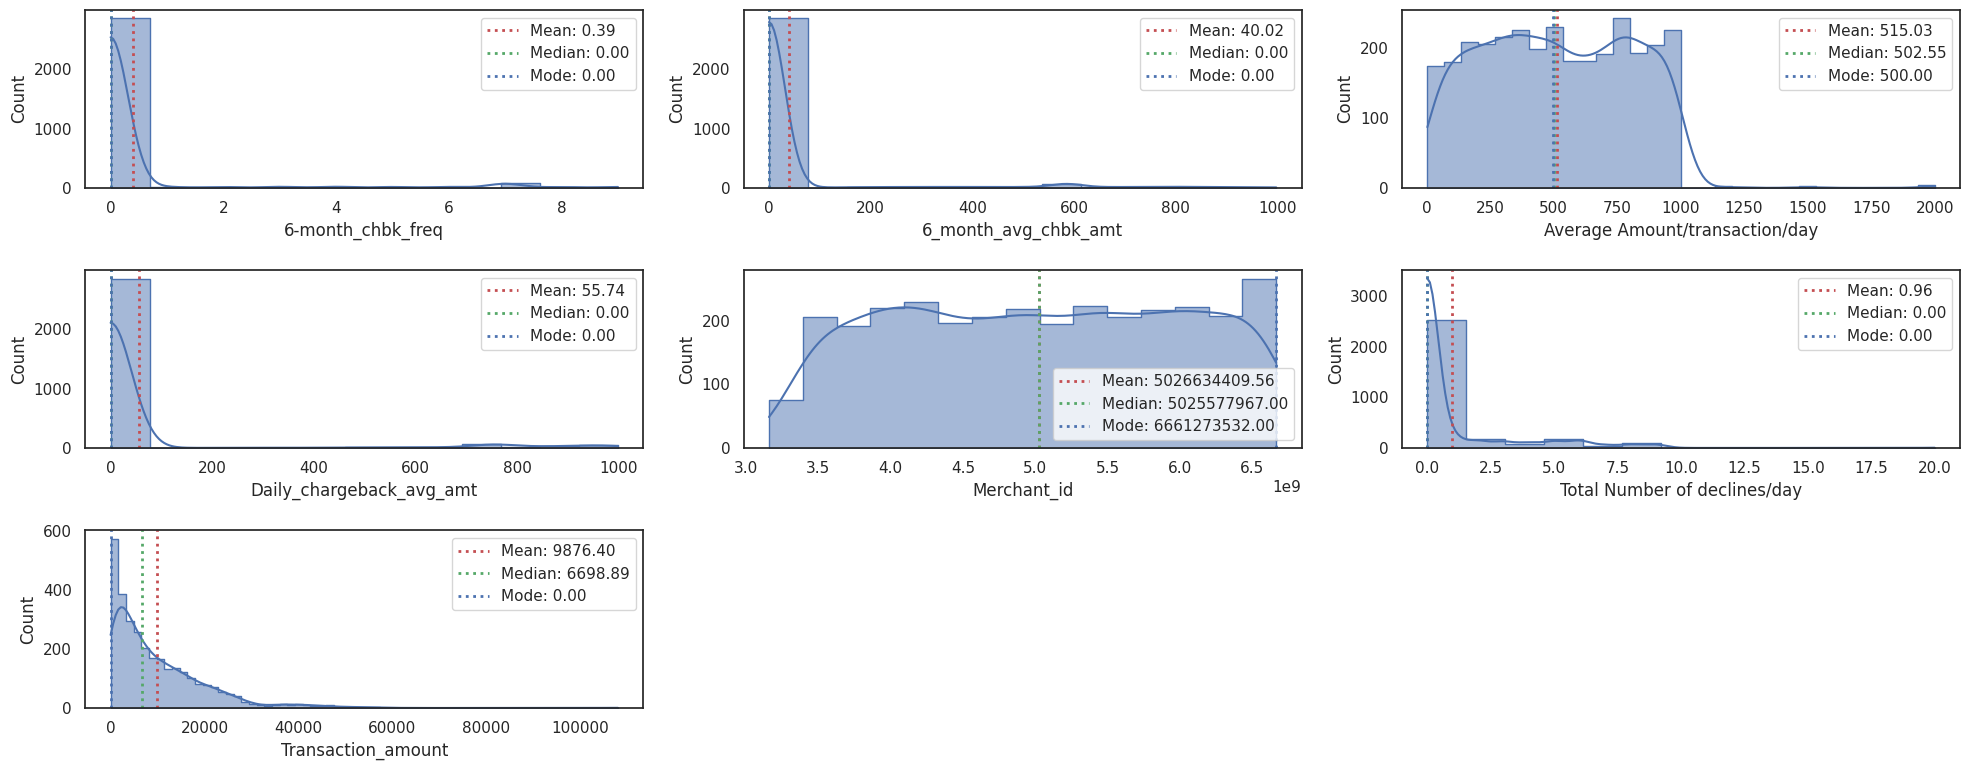

In [ ]:
fig, axs = plt.subplots(nrows = np.ceil(len(numerical_cols)/3).astype(int), ncols = 3, figsize = (20,8))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
  sns.histplot(dataset[col], kde=True, element="step", ax=axs[i])

  mean_value = dataset[col].mean()
  median_value = dataset[col].median()
  mode_value = dataset[col].mode()[0]
  axs[i].axvline(mean_value, color='r', linestyle=':', linewidth=2, label=f'Mean: {mean_value:.2f}')
  axs[i].axvline(median_value, color='g', linestyle=':', linewidth=2, label=f'Median: {median_value:.2f}')
  axs[i].axvline(mode_value, color='b', linestyle=':', linewidth=2, label=f'Mode: {mode_value:.2f}')
  axs[i].legend()

# Hide the unutilized axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(pad=1.5)
plt.show()

### Correlation Analysis

Compute pairwise correlation of columns, using Pearson correlation coefficient

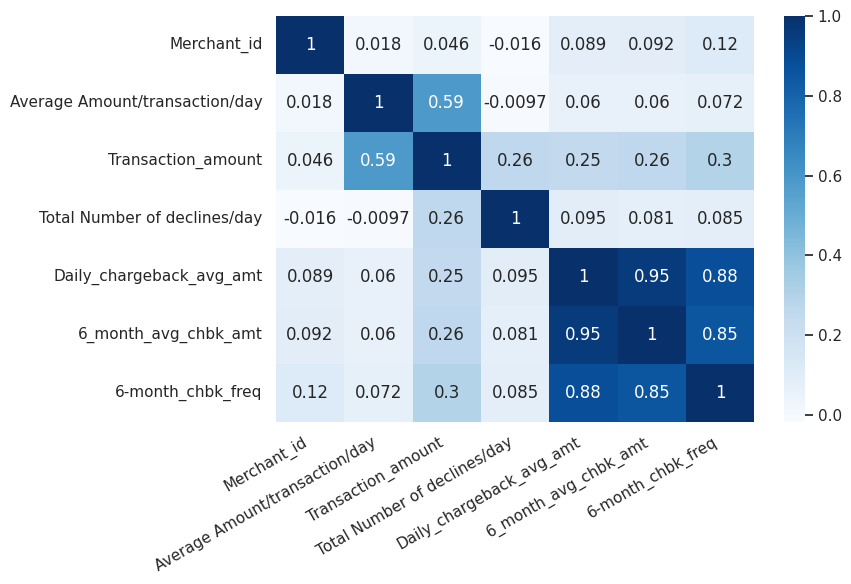

In [ ]:
corrmat = dataset.corr(numeric_only=True)

fig, axs = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, annot=True, cmap="Blues")
plt.xticks(rotation=30, ha='right')
fig.tight_layout()
plt.show()

Daily_chargeback_avg_amt exhibits a very strong positive linear correlation with both 6-month_chbk_freq and 6_month_avg_chbk_amt. Furthermore, the latter two also display a very strong positive linear correlation with each other. Transaction_amount demonstrates a moderate positive linear correlation with Average Amount/transaction/day, while showing a weak positive linear correlation with the other variables, except for Merchant_id. Additionally, Total Number of declines/day exhibits a very weak negative linear correlation with both Merchant_id and Average Amount/transaction/day. The remaining numerical features are characterized by weak positive linear correlations.

### Dataset splitting
The dataset has been split into training, validation and test sets, with proportions of 70%, 15% and 15%, respectively.

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset.iloc[:, :-1],
    dataset.iloc[:, -1],
    test_size = 0.15,
    random_state = seed
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.1764,
    random_state = seed
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(dataset):.2%})")
print(f"Validation set size: {len(X_valid)} ({len(X_valid)/len(dataset):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(dataset):.2%})")

del X_train_val, y_train_val

Training set size: 2152 (69.98%)
Validation set size: 461 (14.99%)
Test set size: 462 (15.02%)


### Missing values

In [ ]:
dataset_na = (dataset.isna().sum() / len(dataset)) * 100
dataset_na = dataset_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':dataset_na})
missing_data

Missing Ratio
Merchant_id                               0.0
Average Amount/transaction/day            0.0
Transaction_amount                        0.0
Is declined                               0.0
Total Number of declines/day              0.0
isForeignTransaction                      0.0
isHighRiskCountry                         0.0
Daily_chargeback_avg_amt                  0.0
6_month_avg_chbk_amt                      0.0
6-month_chbk_freq                         0.0
isFradulent                               0.0

There are no missing values, except for the previously dropped Transaction date feature.

### Data normalization

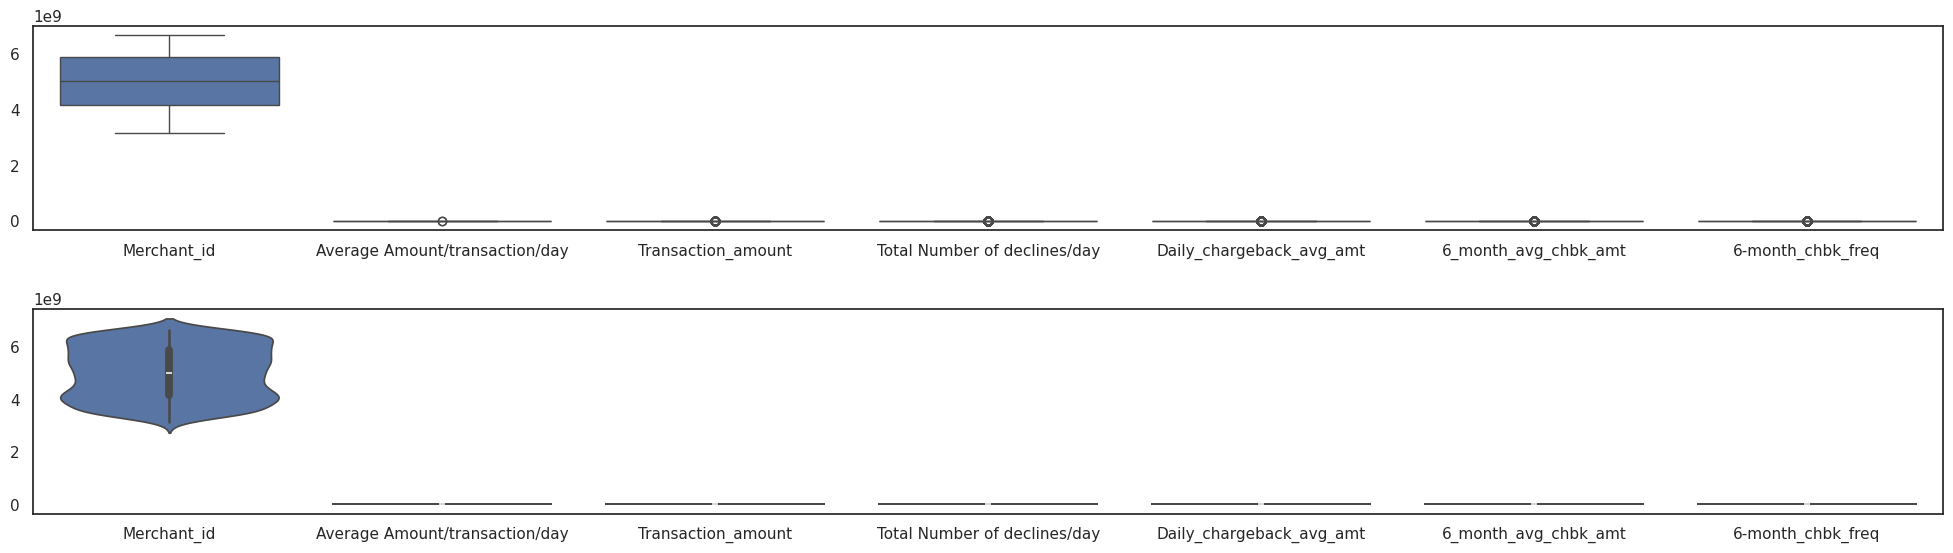

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### Standard Scaler
Standardize features by removing the mean and scaling to unit variance

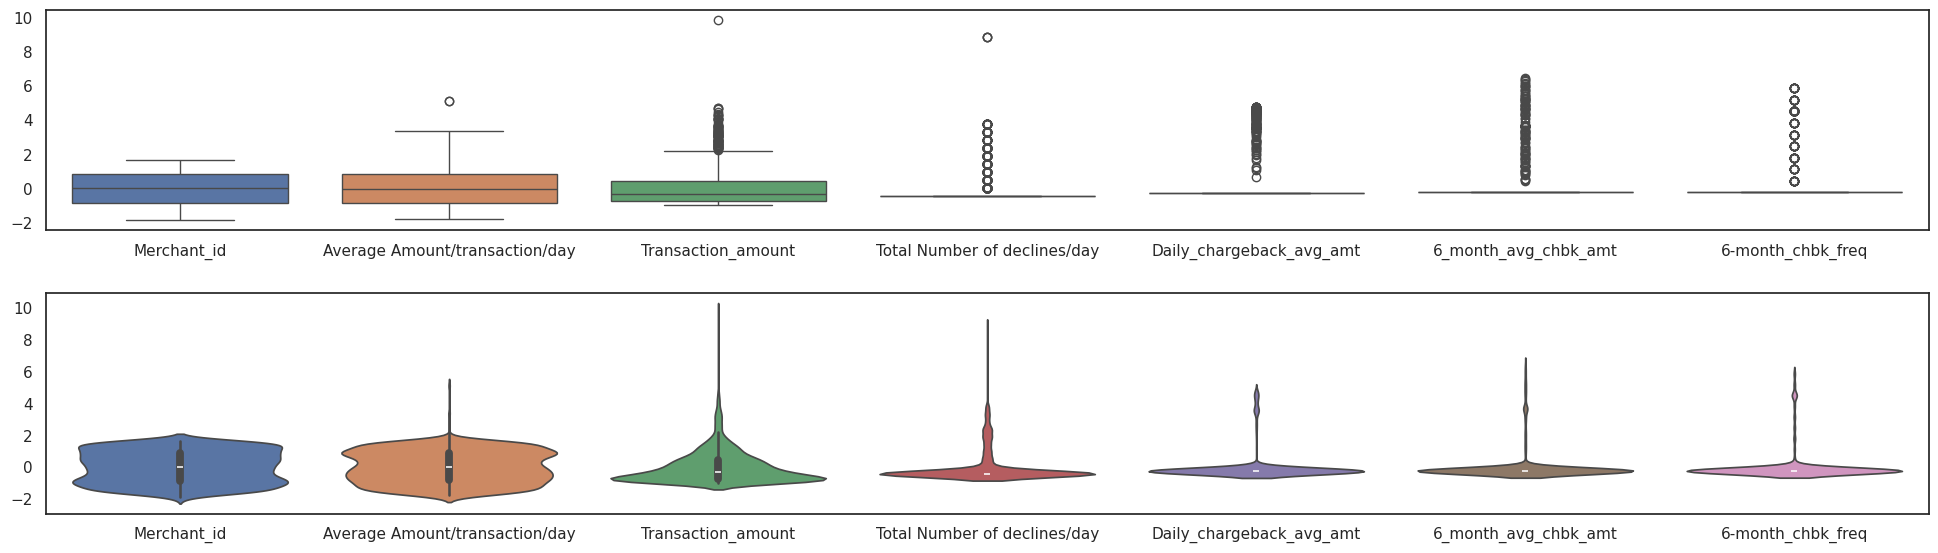

In [ ]:
X_train_scaled = X_train.copy()
scaler = StandardScaler().fit(X_train[numerical_cols])
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train_scaled, ax=axs[0])
sns.violinplot(data=X_train_scaled, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### QuantileTransformer
StandardScaler is sensitive to outliers, as it relies on the mean and standard deviation for scaling, which can be significantly influenced by extreme values. In contrast, QuantileTransformer mitigates the impact of outliers by using quantiles information.
QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution within the range [0, 1], making outliers indistinguishable from inliers.

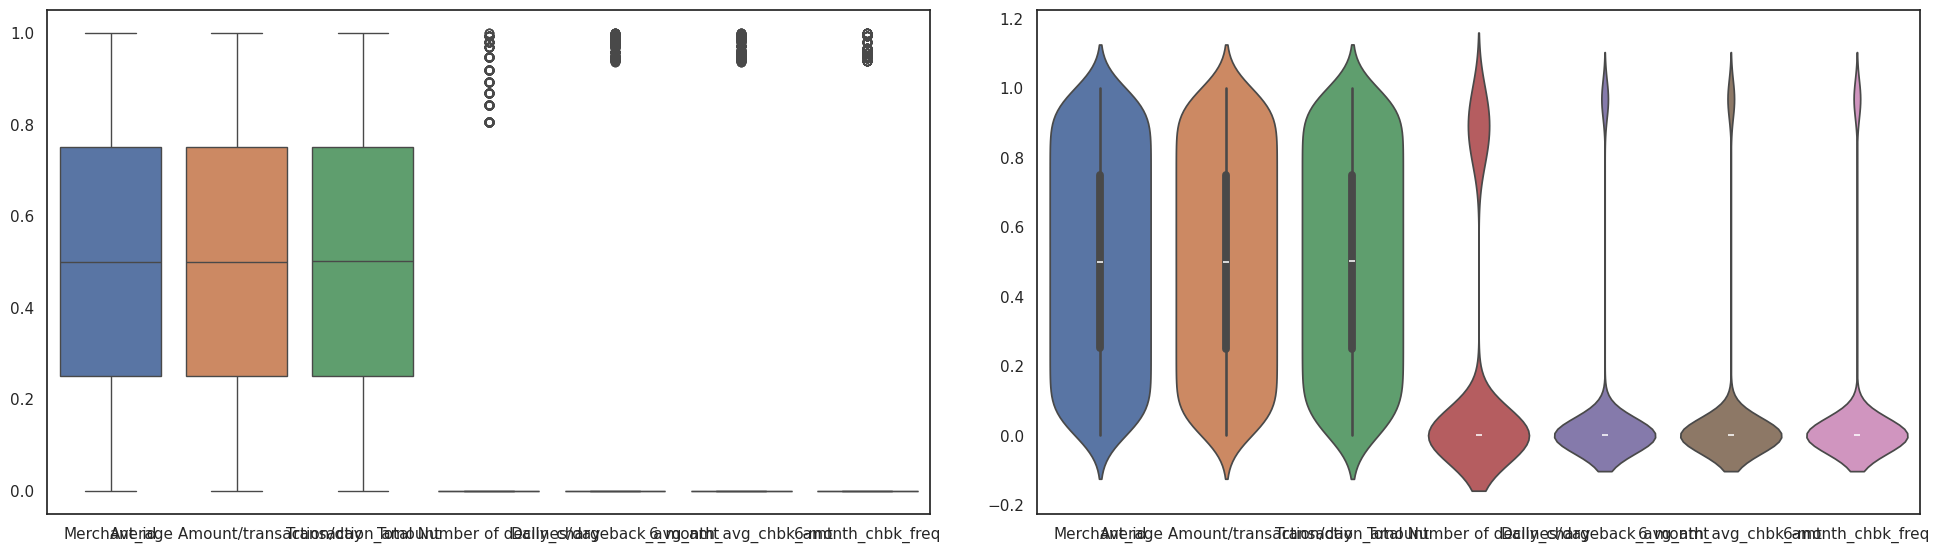

In [ ]:
scaler = QuantileTransformer(random_state=seed).fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])

X_valid[numerical_cols] = scaler.transform(X_valid[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

## HybridIG-CSO algorithm

### Attribute Ranking using IG technique

In [ ]:
ig_values = {}
for col in X_train.columns:
  ig_values[col] = InformationGain(X_train[col], y_train)
  print(f"{col}: {ig_values[col]}")

# Compute the standard deviation of the Information Gain (IG) values
threshold = np.std(list(ig_values.values()))
print(f"\nThreshold: {threshold}")
# Select attributes exceeding or meeting the threshold
ig_attributes = [col for col, ig in ig_values.items() if ig >= threshold]
print(f"Attributes exceeding or meeting the threshold: {ig_attributes}")

Merchant_id: 0.023555305637964263
Average Amount/transaction/day: 0.0055538526221081685
Transaction_amount: 0.13557036540500317
Is declined: 0.026701739837697858
Total Number of declines/day: 0.11726685993579894
isForeignTransaction: 0.13220245938629993
isHighRiskCountry: 0.19621666826283385
Daily_chargeback_avg_amt: 0.06322274352653334
6_month_avg_chbk_amt: 0.06378983054611254
6-month_chbk_freq: 0.08028277648821014

Threshold: 0.05711808284135101
Attributes exceeding or meeting the threshold: ['Transaction_amount', 'Total Number of declines/day', 'isForeignTransaction', 'isHighRiskCountry', 'Daily_chargeback_avg_amt', '6_month_avg_chbk_amt', '6-month_chbk_freq']


### Hyperparameter tuning

In [ ]:
# The threshold for the sigmoid activation function (classifying predictions as positive if they exceed the threshold and negative otherwise)
threshold = 0.5

# Hyperparameter tuning
alpha, beta, gamma, phi = hyperparameter_tuning(
    ig_attributes,
    pd.concat([X_train, X_valid, X_test]), pd.concat([y_train, y_valid, y_test]),
    n_features, categorical_cols, 20, threshold)

Tuning alpha ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning beta ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning gamma ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning phi ...


  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters:  (1, 0.5, 100, 0.5)
Best fitness score:  0.9749160206718346


## Experiment I: Comparisons performance between HybridIG-CSO, RWN with filter approach, and RWN with CSO
In this experiment, the HybridIG-CSO method was evaluated by comparing it with three distinct techniques: the classical RWN, RWN with a filter-based approach (IG-RWN) and manually tuned CSO-RWN. The performance of the HybridIG-CSO method was assessed against the other approaches using six different metrics: Accuracy, Precision, Recall, AUC, F1 and G-mean.

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9610
Precision            |     0.9506
Recall               |     0.8462
F1-Score             |     0.8953
Sensitivity          |     0.9506
Specificity          |     0.9633
G-Mean               |     0.9569
AUC                  |     0.9569

Classical RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9567
Precision            |     0.8765
Recall               |     0.8765
F1-Score             |     0.8765
Sensitivity          |     0.8765
Specificity          |     0.9738
G-Mean               |     0.9239
AUC                  |     0.9251

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9567
Precision            |     0.9383
Recall               |     0.8352
F1-Score             |     0.8837
Sensitivity          |    

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9707
Precision            |     0.9755
Recall               |     0.9665
F1-Score             |     0.9709
Sensitivity          |     0.9755
Specificity          |     0.9661
G-Mean               |     0.9707
AUC                  |     0.9708

Classical RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9720
Precision            |     0.9722
Recall               |     0.9721
F1-Score             |     0.9721
Sensitivity          |     0.9722
Specificity          |     0.9723
G-Mean               |     0.9722
AUC                  |     0.9722

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9730
Precision            |     0.9781
Recall               |     0.9683
F1-Score             |     0.9732
Sensitivity          |    

## Experiment II: Comparison with other classifiers
In this experimental evaluation, the effectiveness of the HybridIG-CSO is assessed in the context of fraud classification, by comparing its performance against other widely employed algorithms typically used as induction techniques in feature selection wrapper-based methods, namely Naïve Bayes (NB), Random Forest (RF) and Support Vector Machine (SVM).

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, NB_best_scores, RF_best_scores, SVM_best_scores = experiment2(
    ig_attributes,
    pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
    X_test, y_test,
    categorical_cols, n_features,
    alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9610
Precision            |     0.9506
Recall               |     0.8462
F1-Score             |     0.8953
Sensitivity          |     0.9506
Specificity          |     0.9633
G-Mean               |     0.9569
AUC                  |     0.9569

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9113
Precision            |     0.7284
Recall               |     0.7564
F1-Score             |     0.7421
Sensitivity          |     0.7284
Specificity          |     0.9501
G-Mean               |     0.8319
AUC                  |     0.8393

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9762
Precision            |     0.9753
Recall               |     0.8977
F1-Score             |     0.9349
Sensitivity

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment2(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9707
Precision            |     0.9755
Recall               |     0.9665
F1-Score             |     0.9709
Sensitivity          |     0.9755
Specificity          |     0.9661
G-Mean               |     0.9707
AUC                  |     0.9708

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.8413
Precision            |     0.7125
Recall               |     0.9588
F1-Score             |     0.8173
Sensitivity          |     0.7125
Specificity          |     0.9697
G-Mean               |     0.8311
AUC                  |     0.8411

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9897
Precision            |     0.9955
Recall               |     0.9841
F1-Score             |     0.9898
Sensitivity

In [ ]:
del dataset, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, categorical_cols, kf, ig_values, ig_attributes, alpha, beta, gamma, phi, threshold

# Dataset 3 - Default of Credit Card Clients
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

## Dataset Analysis

In [ ]:
dataset = pd.read_excel(path + 'DefaultofCreditCardClients.xls', header=1)

# Remove ID column
dataset.drop('ID', axis=1, inplace=True)

# Retrieve the categorical columns from the dataframe
categorical_cols = dataset.iloc[:, :-1].select_dtypes(include=['object']).columns.tolist()
# Retrieve the numerical columns from the dataframe
numerical_cols = dataset.iloc[:, :-1].columns.difference(categorical_cols).tolist()

n_features = len(dataset.columns) - 1

print(f"# samples = {len(dataset)}")
print(f"# features = {n_features}")
print(f"target: {dataset.columns[-1]}")

# samples = 30000
# features = 23
target: default payment next month


In [ ]:
dataset

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0          20000    2          2         1   24      2      2     -1     -1   
1         120000    2          2         2   26     -1      2      0      0   
2          90000    2          2         2   34      0      0      0      0   
3          50000    2          2         1   37      0      0      0      0   
4          50000    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995     220000    1          3         1   39      0      0      0      0   
29996     150000    1          3         2   43     -1     -1     -1     -1   
29997      30000    1          2         2   37      4      3      2     -1   
29998      80000    1          3         1   41      1     -1      0      0   
29999      50000    1          2         1   46      0      0      0      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -2  ...          0          0          0         0       689   
1          0  ...       3272       3455       3261         0      1000   
2          0  ...      14331      14948      15549      1518      1500   
3          0  ...      28314      28959      29547      2000      2019   
4          0  ...      20940      19146      19131      2000     36681   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...      88004      31237      15980      8500     20000   
29996      0  ...       8979       5190          0      1837      3526   
29997      0  ...      20878      20582      19357         0         0   
29998      0  ...      52774      11855      48944     85900      3409   
29999      0  ...      36535      32428      15313      2078      1800   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0             0         0         0         0                           1  
1          1000      1000         0      2000                           1  
2          1000      1000      1000      5000                           0  
3          1200      1100      1069      1000                           0  
4         10000      9000       689       679                           0  
...         ...       ...       ...       ...                         ...  
29995      5003      3047      5000      1000                           0  
29996      8998       129         0         0                           0  
29997     22000      4200      2000      3100                           1  
29998      1178      1926     52964      1804                           1  
29999      1430      1000      1000      1000                           1  

[30000 rows x 24 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

### Skewness

Skewness is a statistical measure that quantifies the asymmetry of the distribution of values in a dataset. It indicates whether the data points are skewed to the left (negative skew) or the right (positive skew) relative to the mean.

*   **Positive Skewness (Right Skew)**: the majority of data points are concentrated on the left side of the distribution, with a few extreme values on the right side.
<center> Mean > Median > Mode </center>

*   **Negative Skewness (Left Skew)**: most of the data points are concentrated on the right side of the distribution, while a few extreme values on the left side.
<center> Mean < Median < Mode </center>

*   **Zero Skewness (Symmetrical Distribution)**: perfectly symmetrical distribution, where the mean, median, and mode are equal. In such a distribution, the data points are evenly distributed around the central point.

In [ ]:
# Compute the skewness only for non missing variables
skewed_feats = dataset[numerical_cols].apply(lambda x: skew(x.dropna()))
skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
skewness

Variable   Skewness
0   LIMIT_BAL   0.992817
1         SEX  -0.424162
2   EDUCATION   0.970923
3    MARRIAGE  -0.018741
4         AGE   0.732209
5       PAY_0   0.731938
6       PAY_2   0.790525
7       PAY_3   0.840640
8       PAY_4   0.999579
9       PAY_5   1.008147
10      PAY_6   0.947982
11  BILL_AMT1   2.663728
12  BILL_AMT2   2.705086
13  BILL_AMT3   3.087676
14  BILL_AMT4   2.821824
15  BILL_AMT5   2.876236
16  BILL_AMT6   2.846502
17   PAY_AMT1  14.667631
18   PAY_AMT2  30.452295
19   PAY_AMT3  17.215775
20   PAY_AMT4  12.904340
21   PAY_AMT5  11.126861
22   PAY_AMT6  10.640195

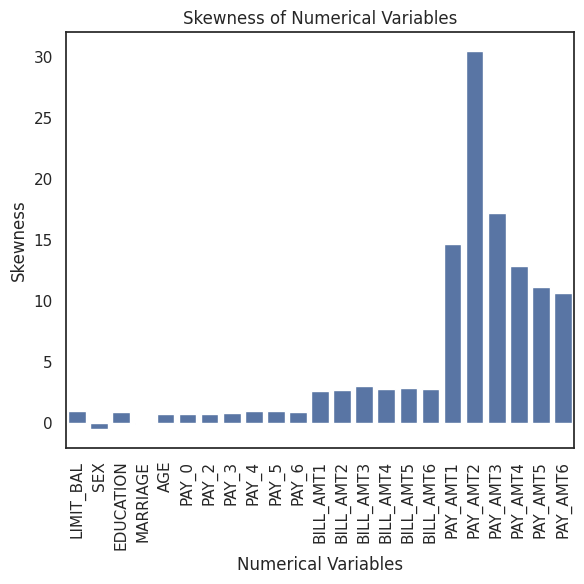

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.xticks(rotation=90)
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.xlabel('Numerical Variables')
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Variables')
plt.tight_layout()
plt.show()

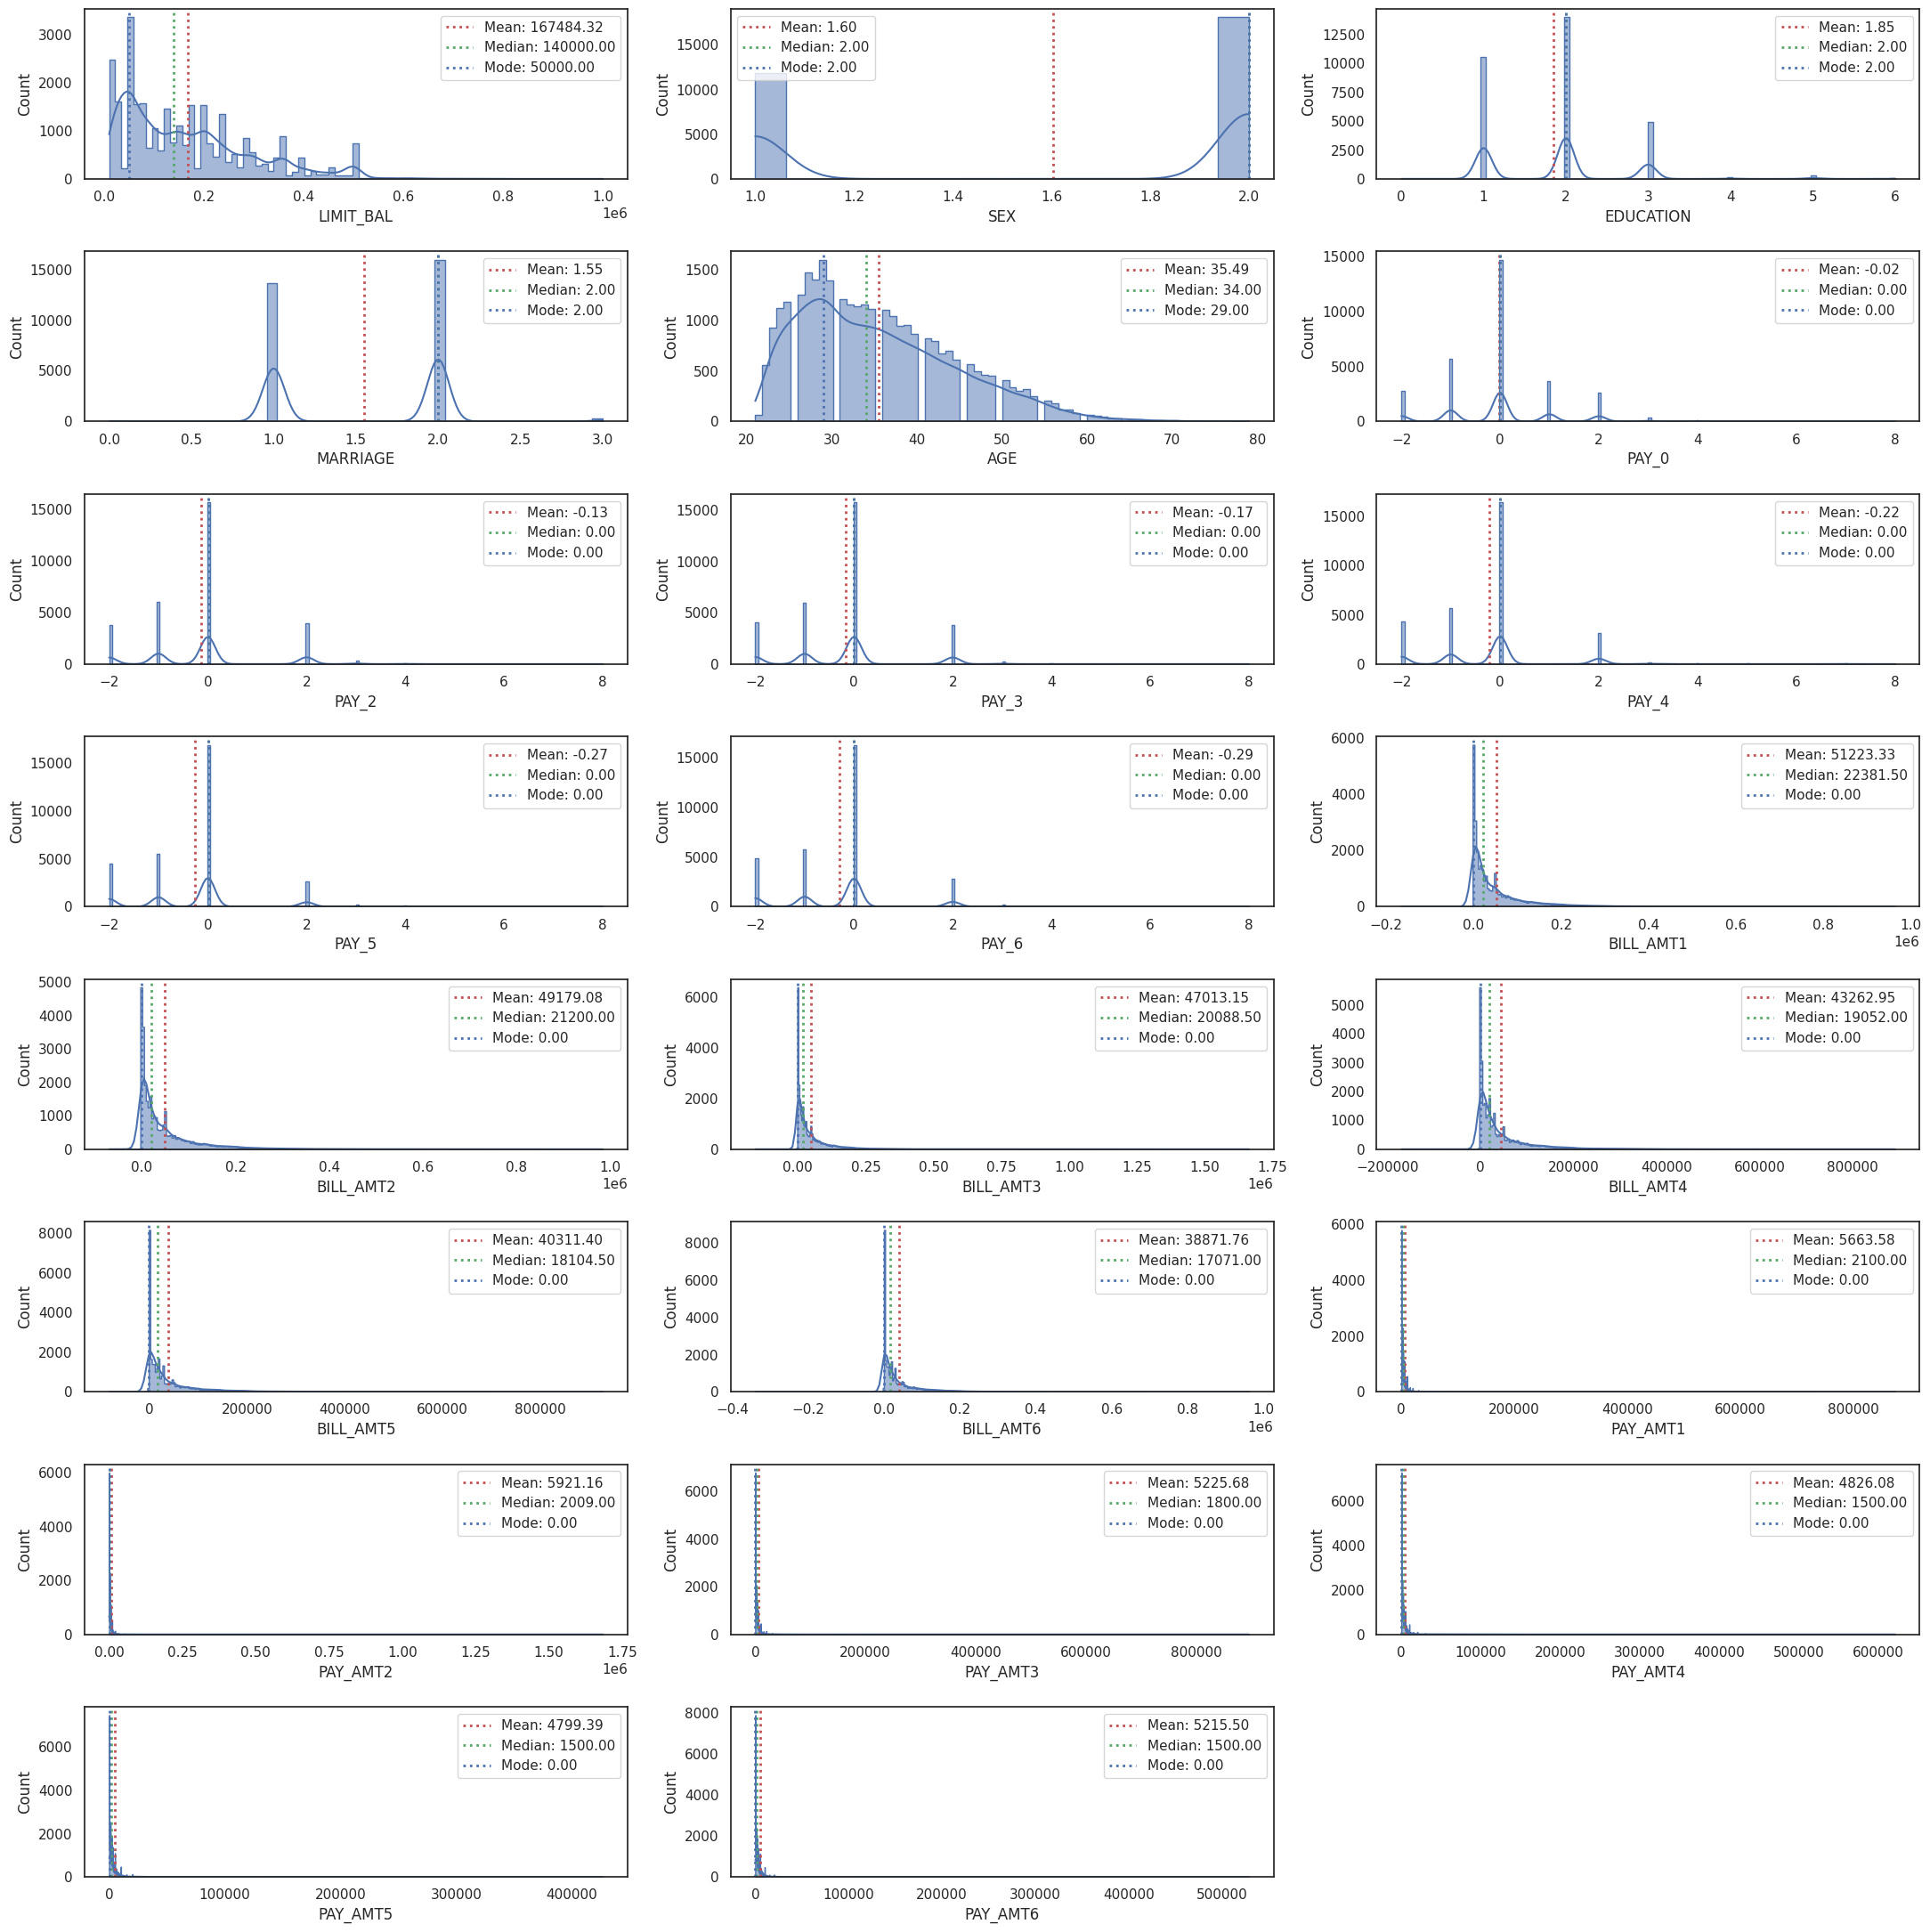

In [ ]:
fig, axs = plt.subplots(nrows = np.ceil(len(numerical_cols)/3).astype(int), ncols = 3, figsize = (22,22))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
  sns.histplot(dataset[col], kde=True, element="step", ax=axs[i])

  mean_value = dataset[col].mean()
  median_value = dataset[col].median()
  mode_value = dataset[col].mode()[0]
  axs[i].axvline(mean_value, color='r', linestyle=':', linewidth=2, label=f'Mean: {mean_value:.2f}')
  axs[i].axvline(median_value, color='g', linestyle=':', linewidth=2, label=f'Median: {median_value:.2f}')
  axs[i].axvline(mode_value, color='b', linestyle=':', linewidth=2, label=f'Mode: {mode_value:.2f}')
  axs[i].legend()

# Hide the unutilized axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(pad=1.5)
plt.show()

### Correlation Analysis

Compute pairwise correlation of columns, using Pearson correlation coefficient

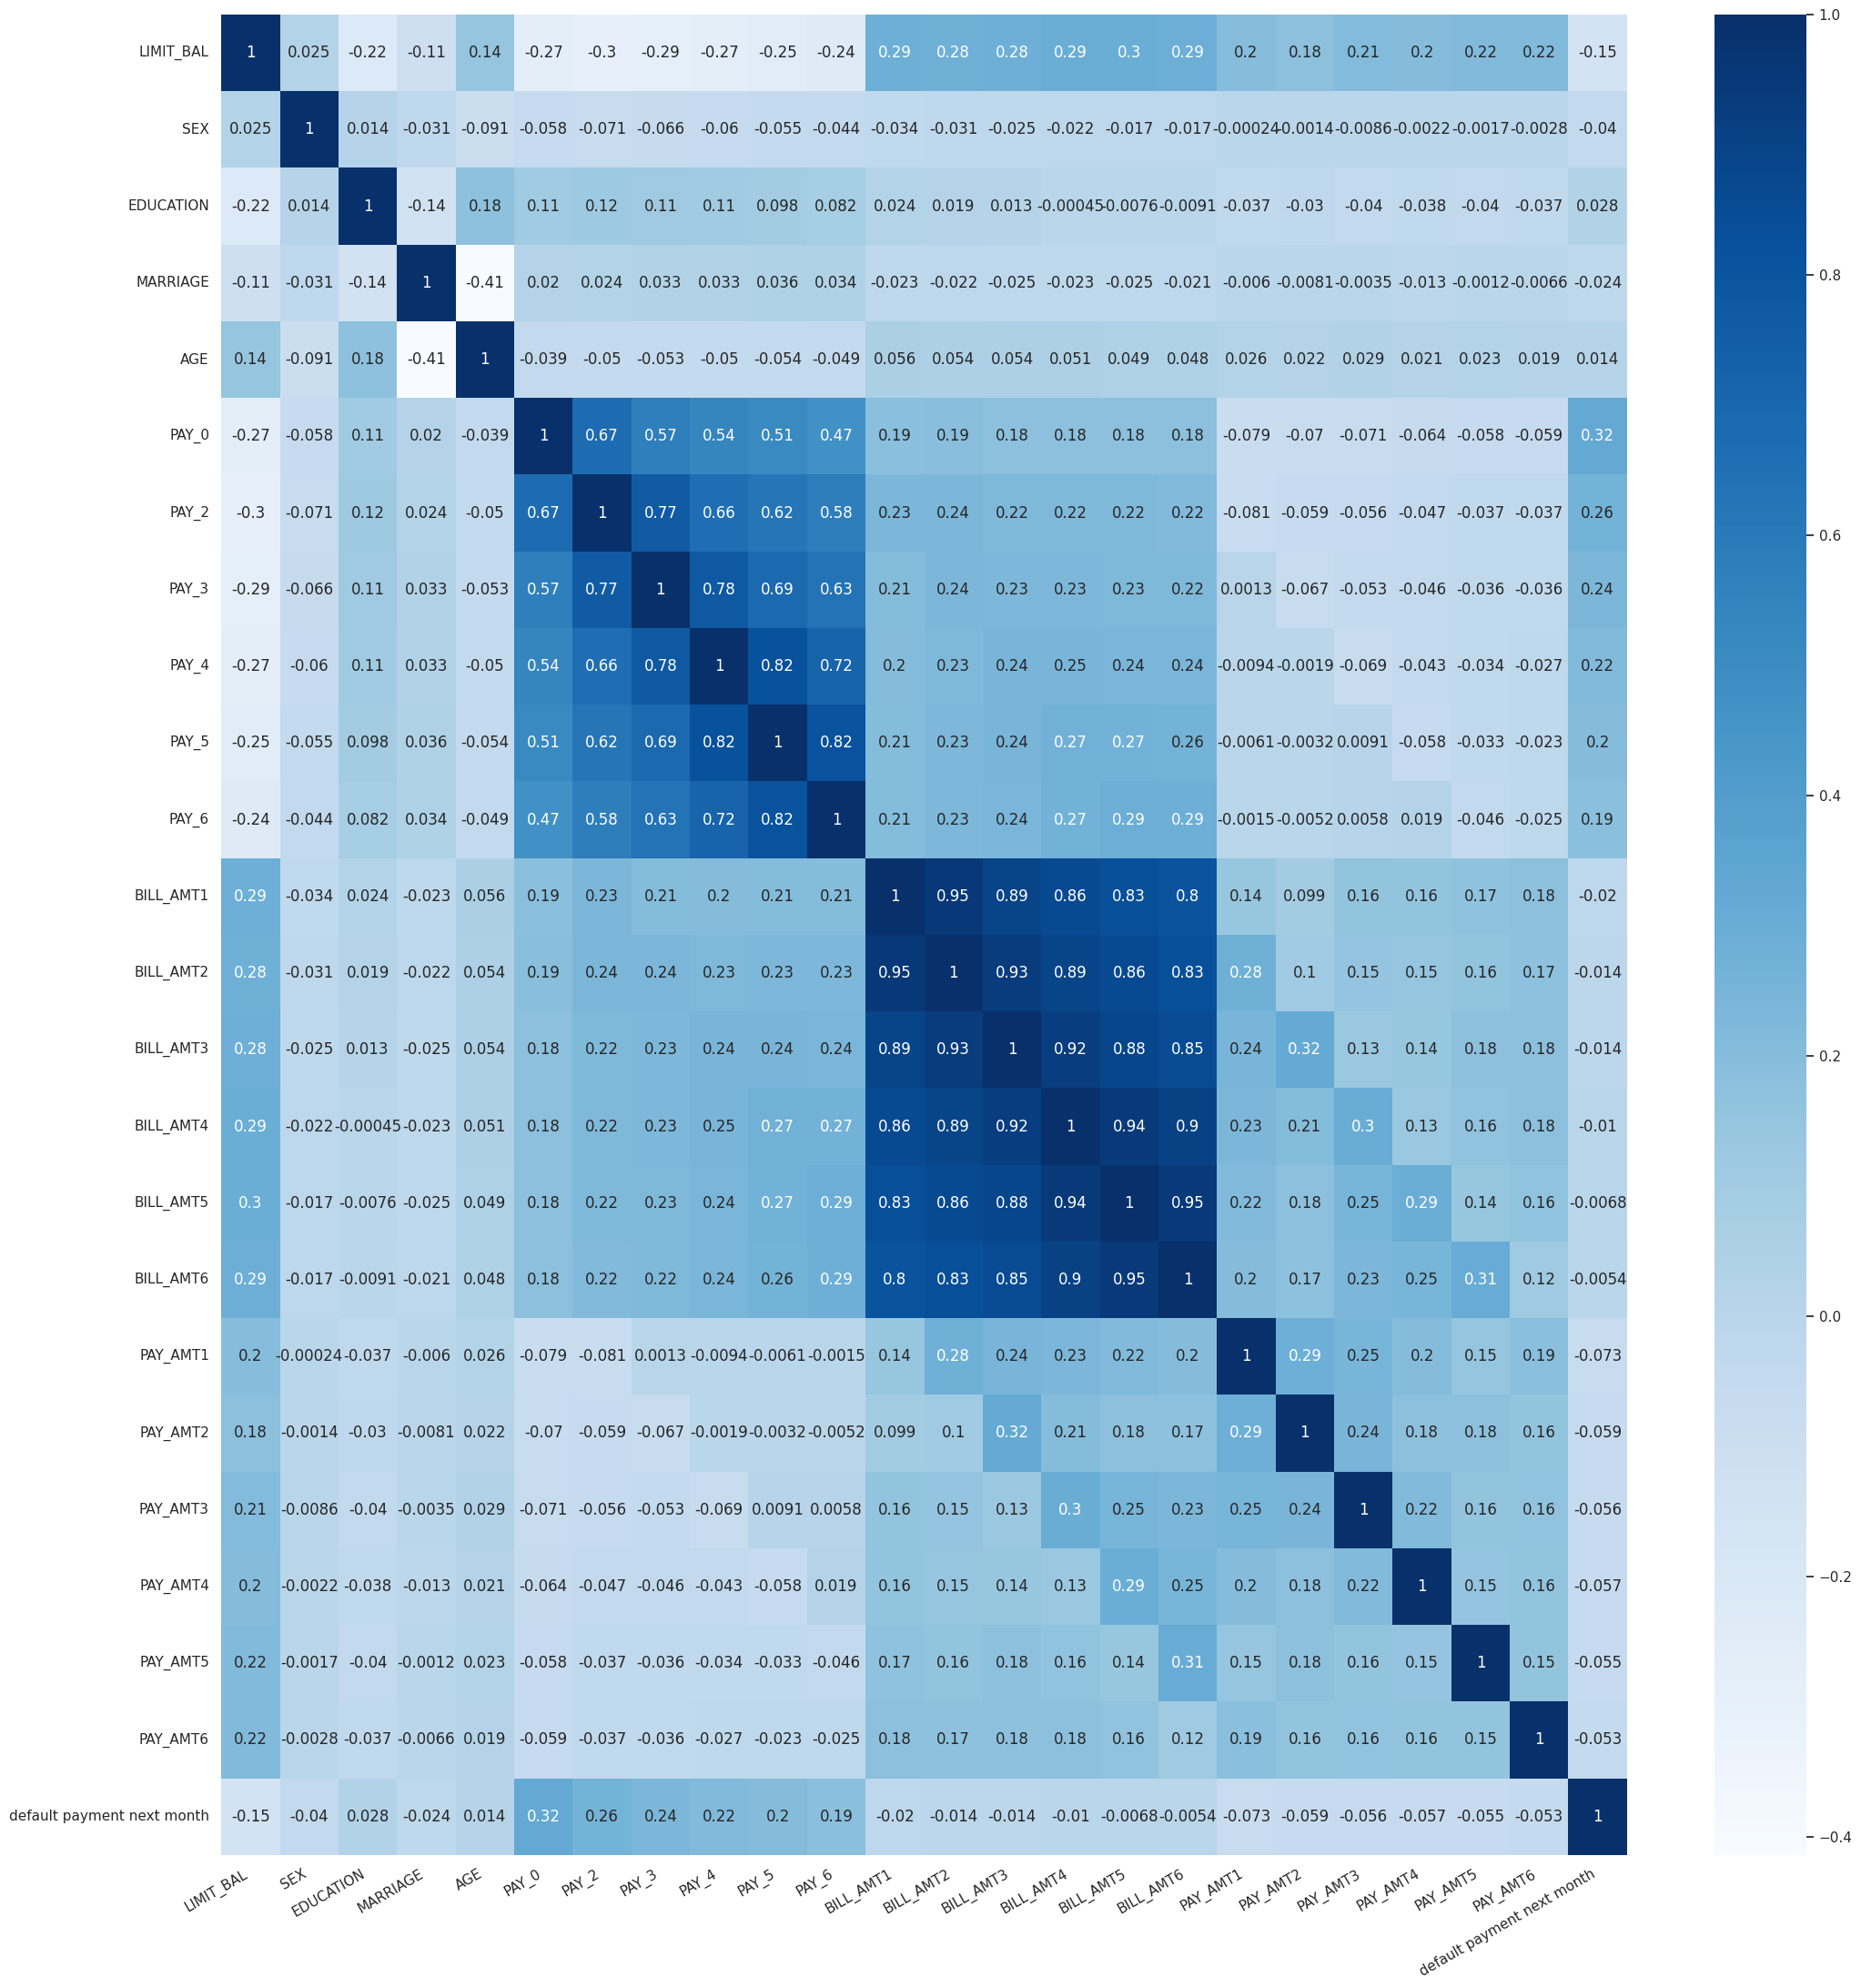

In [ ]:
corrmat = dataset.corr(numeric_only=True)

fig, axs = plt.subplots(figsize=(22, 22))
sns.heatmap(corrmat, annot=True, cmap="Blues")
plt.xticks(rotation=30, ha='right')
fig.tight_layout()
plt.show()

### Dataset splitting
The dataset has been split into training, validation and test sets, with proportions of 70%, 15% and 15%, respectively.

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset.iloc[:, :-1],
    dataset.iloc[:, -1],
    test_size = 0.15,
    random_state = seed
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.1764,
    random_state = seed
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(dataset):.2%})")
print(f"Validation set size: {len(X_valid)} ({len(X_valid)/len(dataset):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(dataset):.2%})")

del X_train_val, y_train_val

Training set size: 21001 (70.00%)
Validation set size: 4499 (15.00%)
Test set size: 4500 (15.00%)


### Missing values

In [ ]:
dataset_na = (dataset.isna().sum() / len(dataset)) * 100
dataset_na = dataset_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':dataset_na})
missing_data

Missing Ratio
LIMIT_BAL                             0.0
SEX                                   0.0
PAY_AMT6                              0.0
PAY_AMT5                              0.0
PAY_AMT4                              0.0
PAY_AMT3                              0.0
PAY_AMT2                              0.0
PAY_AMT1                              0.0
BILL_AMT6                             0.0
BILL_AMT5                             0.0
BILL_AMT4                             0.0
BILL_AMT3                             0.0
BILL_AMT2                             0.0
BILL_AMT1                             0.0
PAY_6                                 0.0
PAY_5                                 0.0
PAY_4                                 0.0
PAY_3                                 0.0
PAY_2                                 0.0
PAY_0                                 0.0
AGE                                   0.0
MARRIAGE                              0.0
EDUCATION                             0.0
default payment next month            0.0

There are no missing values.

### Data normalization

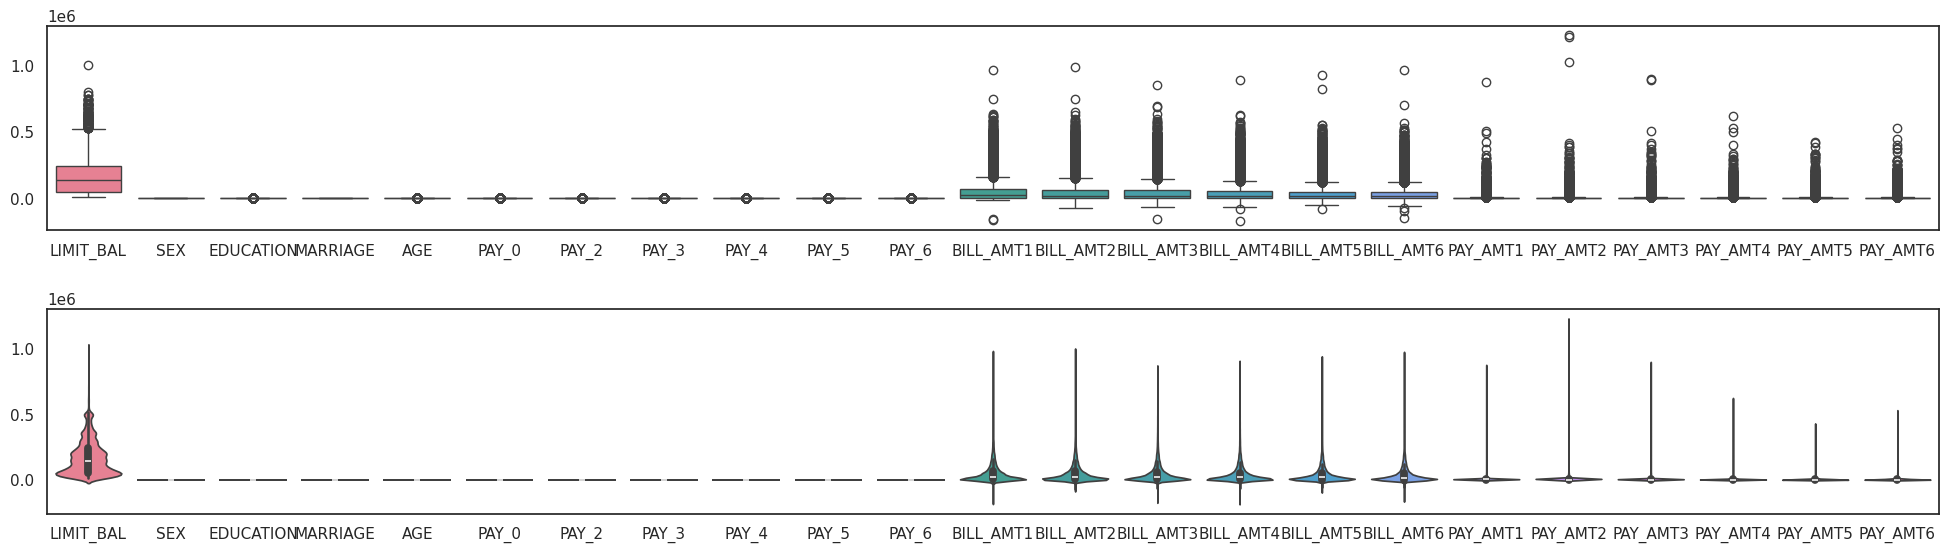

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### Standard Scaler
Standardize features by removing the mean and scaling to unit variance

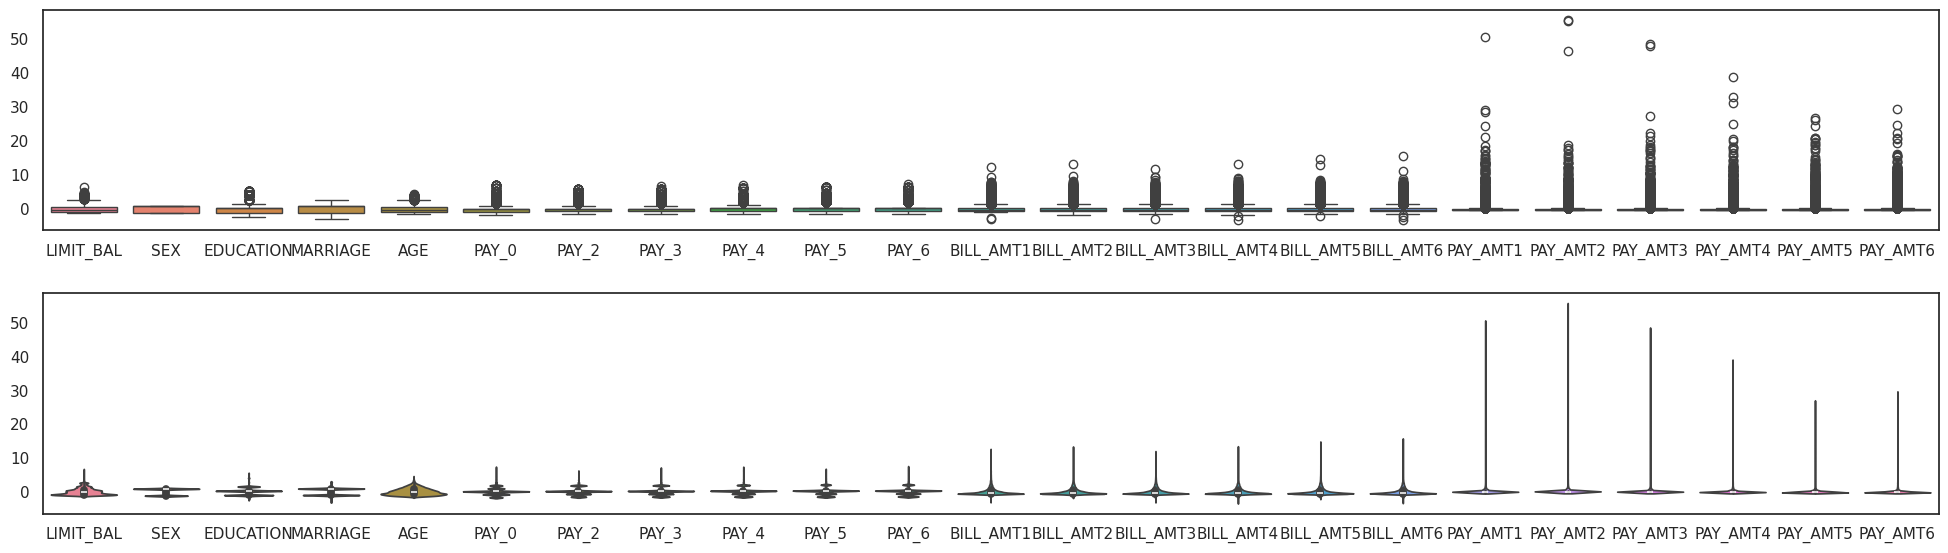

In [ ]:
X_train_scaled = X_train.copy()
scaler = StandardScaler().fit(X_train[numerical_cols])
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train_scaled, ax=axs[0])
sns.violinplot(data=X_train_scaled, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### QuantileTransformer
StandardScaler is sensitive to outliers, as it relies on the mean and standard deviation for scaling, which can be significantly influenced by extreme values. In contrast, QuantileTransformer mitigates the impact of outliers by using quantiles information.
QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution within the range [0, 1], making outliers indistinguishable from inliers.

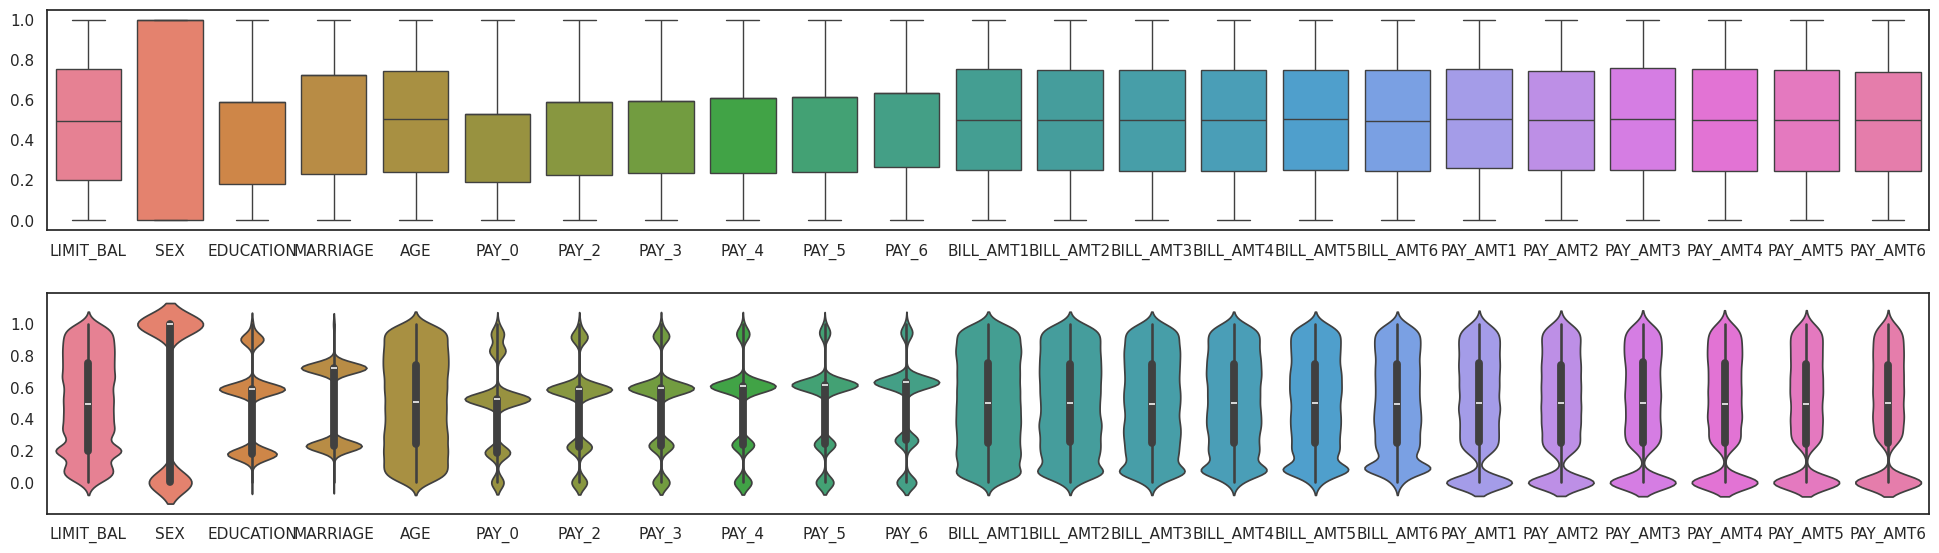

In [ ]:
scaler = QuantileTransformer(random_state=seed).fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])

X_valid[numerical_cols] = scaler.transform(X_valid[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

## HybridIG-CSO algorithm

### Attribute Ranking using IG technique

In [ ]:
ig_values = {}
for col in X_train.columns:
  ig_values[col] = InformationGain(X_train[col], y_train)
  print(f"{col}: {ig_values[col]}")

# Compute the standard deviation of the Information Gain (IG) values
threshold = np.std(list(ig_values.values()))
print(f"\nThreshold: {threshold}")
# Select attributes exceeding or meeting the threshold
ig_attributes = [col for col, ig in ig_values.items() if ig >= threshold]
print(f"Attributes exceeding or meeting the threshold: {ig_attributes}")

LIMIT_BAL: 0.017289366693270303
SEX: 0.0011367189943345402
EDUCATION: 0.0024010408635390945
MARRIAGE: 0.0007831714508585996
AGE: 0.0010323601218643619
PAY_0: 0.0918087458363116
PAY_2: 0.07108204213867353
PAY_3: 0.05364586262159299
PAY_4: 0.04637506632695931
PAY_5: 0.04121777910632396
PAY_6: 0.034655926863054076
BILL_AMT1: 0.0008188488364107016
BILL_AMT2: 0.0006392369995997793
BILL_AMT3: 0.0006487102373569087
BILL_AMT4: 0.0004789516203238531
BILL_AMT5: 0.0005584601319438276
BILL_AMT6: 0.0004264009457316531
PAY_AMT1: 0.0172043543017818
PAY_AMT2: 0.01158528798852343
PAY_AMT3: 0.011020161066032208
PAY_AMT4: 0.009429111726063977
PAY_AMT5: 0.00749039767746873
PAY_AMT6: 0.009002558121816162

Threshold: 0.02504872696828761
Attributes exceeding or meeting the threshold: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


### Hyperparameter tuning

In [ ]:
# The threshold for the sigmoid activation function (classifying predictions as positive if they exceed the threshold and negative otherwise)
threshold = 0.5

# Hyperparameter tuning
alpha, beta, gamma, phi = hyperparameter_tuning(
    ig_attributes,
    pd.concat([X_train, X_valid, X_test]), pd.concat([y_train, y_valid, y_test]),
    n_features, categorical_cols, 20, threshold)

Tuning alpha ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning beta ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning gamma ...


  0%|          | 0/5 [00:00<?, ?it/s]

Tuning phi ...


  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters:  (1, 0.001, 0.5, 0.5)
Best fitness score:  0.8234369121280116


## Experiment I: Comparisons performance between HybridIG-CSO, RWN with filter approach, and RWN with CSO
In this experiment, the HybridIG-CSO method was evaluated by comparing it with three distinct techniques: the classical RWN, RWN with a filter-based approach (IG-RWN) and manually tuned CSO-RWN. The performance of the HybridIG-CSO method was assessed against the other approaches using six different metrics: Accuracy, Precision, Recall, AUC, F1 and G-mean.

Due to the limitations of the free usage plans on Colab and Kaggle, it was necessary to significantly reduce the number of features, as the initialization of the RWN exhausted all the available RAM. Consequently, it was not feasible to implement the classical RWN and the manually tuned CSO-RWN, as these require the use of the full dataset's features.

In [ ]:
def experiment1(ig_attributes, X_train, y_train, X_test, y_test, categorical_cols, dataset_features, alpha, beta, gamma, phi, threshold, max_iter=100, kf=None) -> tuple:
  # IG-RWN
  particle_IGRWN = create_particles([ig_attributes], ig_attributes)[0]
  # Determine whether to perform testing with 10-Fold Cross-Validation or a separate test set
  if kf is not None:
    X, y = perform_SMOTE(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), categorical_cols)
    # HybridIG-CSO
    HIGCSO_best_scores = HIGCSO_kFoldCV(kf, ig_attributes, X, y, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # IG-RWN
    IGRWN_scores = RWN_kFoldCV(kf, particle_IGRWN, X, y, threshold)
  else:
    X, y = perform_SMOTE(X_train, y_train, categorical_cols)
    # HybridIG-CSO
    _, HIGCSO_best_scores = test_model(ig_attributes, X, y, X_test, y_test, dataset_features, alpha, beta, gamma, phi, threshold, max_iter)
    # IG-RWN
    y_true = LabelEncoder().fit_transform(y_test)
    B = RWN_model(particle_IGRWN, X, y)
    pred = compute_pred(particle_IGRWN, X, y, X_test, threshold)
    IGRWN_scores = compute_metrics(pred, y_true)
  print('\033[34mHybridIG-CSO \033[0m')
  print_metrics(HIGCSO_best_scores)
  print('\033[34m\nIG-RWN \033[0m')
  print_metrics(IGRWN_scores)
  return HIGCSO_best_scores, IGRWN_scores

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, IGRWN_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7793
Precision            |     0.5753
Recall               |     0.5044
F1-Score             |     0.5375
Sensitivity          |     0.5753
Specificity          |     0.8379
G-Mean               |     0.6943
AUC                  |     0.7066

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7831
Precision            |     0.5494
Recall               |     0.5126
F1-Score             |     0.5303
Sensitivity          |     0.5494
Specificity          |     0.8502
G-Mean               |     0.6834
AUC                  |     0.6998


### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, IGRWN_scores = experiment1(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.6897
Precision            |     0.5490
Recall               |     0.7640
F1-Score             |     0.6389
Sensitivity          |     0.5490
Specificity          |     0.8304
G-Mean               |     0.6752
AUC                  |     0.6897

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.6980
Precision            |     0.5582
Recall               |     0.7749
F1-Score             |     0.6490
Sensitivity          |     0.5582
Specificity          |     0.8378
G-Mean               |     0.6839
AUC                  |     0.6980


## Experiment II: Comparison with other classifiers
In this experimental evaluation, the effectiveness of the HybridIG-CSO is assessed in the context of fraud classification, by comparing its performance against other widely employed algorithms typically used as induction techniques in feature selection wrapper-based methods, namely Naïve Bayes (NB), Random Forest (RF) and Support Vector Machine (SVM).

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, NB_best_scores, RF_best_scores, SVM_best_scores = experiment2(
    ig_attributes,
    pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
    X_test, y_test,
    categorical_cols, n_features,
    alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.7793
Precision            |     0.5753
Recall               |     0.5044
F1-Score             |     0.5375
Sensitivity          |     0.5753
Specificity          |     0.8379
G-Mean               |     0.6943
AUC                  |     0.7066

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.6769
Precision            |     0.6630
Recall               |     0.3734
F1-Score             |     0.4777
Sensitivity          |     0.6630
Specificity          |     0.6809
G-Mean               |     0.6719
AUC                  |     0.6719

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.8047
Precision            |     0.4576
Recall               |     0.5781
F1-Score             |     0.5109
Sensitivity

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment2(
  ig_attributes,
  pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]),
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.6876
Precision            |     0.5455
Recall               |     0.7621
F1-Score             |     0.6358
Sensitivity          |     0.5455
Specificity          |     0.8297
G-Mean               |     0.6727
AUC                  |     0.6876

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.6724
Precision            |     0.6657
Recall               |     0.6748
F1-Score             |     0.6702
Sensitivity          |     0.6657
Specificity          |     0.6791
G-Mean               |     0.6723
AUC                  |     0.6724

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.8768
Precision            |     0.8525
Recall               |     0.8960
F1-Score             |     0.8737
Sensitivity

In [ ]:
del dataset, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, categorical_cols, kf, ig_values, ig_attributes, alpha, beta, gamma, phi, threshold

# Dataset 4 - European cardholders
https://kaggle.com/mlg-ulb/creditcardfraud

## Dataset Analysis

In [16]:
dataset = pd.read_csv(path + 'EuropeanCardholders.csv')

# Retrieve the categorical columns from the dataframe
categorical_cols = dataset.iloc[:, :-1].select_dtypes(include=['object']).columns.tolist()
# Retrieve the numerical columns from the dataframe
numerical_cols = dataset.iloc[:, :-1].columns.difference(categorical_cols).tolist()

n_features = len(dataset.columns) - 1

print(f"# samples = {len(dataset)}")
print(f"# features = {n_features}")
print(f"target: {dataset.columns[-1]}")

# samples = 284807
# features = 30
target: Class


In [ ]:
dataset

Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.018307  0.277838   
1      -0.082361 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672   
2       1.800499  0.791461  0.247676 -1.514654  ...  0.247998  0.771679   
3       1.247203  0.237609  0.377436 -1.387024  ... -0.108300  0.005274   
4       0.095921  0.592941 -0.270533  0.817739  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99   
...          ...       ...       ...       ...       ...       ...     ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[284807 rows x 31 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Skewness

Skewness is a statistical measure that quantifies the asymmetry of the distribution of values in a dataset. It indicates whether the data points are skewed to the left (negative skew) or the right (positive skew) relative to the mean.

*   **Positive Skewness (Right Skew)**: the majority of data points are concentrated on the left side of the distribution, with a few extreme values on the right side.
<center> Mean > Median > Mode </center>

*   **Negative Skewness (Left Skew)**: most of the data points are concentrated on the right side of the distribution, while a few extreme values on the left side.
<center> Mean < Median < Mode </center>

*   **Zero Skewness (Symmetrical Distribution)**: perfectly symmetrical distribution, where the mean, median, and mode are equal. In such a distribution, the data points are evenly distributed around the central point.

In [ ]:
# Compute the skewness only for non missing variables
skewed_feats = dataset[numerical_cols].apply(lambda x: skew(x.dropna()))
skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
skewness

Variable   Skewness
0      Time  -0.035567
1        V1  -3.280650
2        V2  -4.624841
3        V3  -2.240144
4        V4   0.676289
5        V5  -2.425889
6        V6   1.826571
7        V7   2.553894
8        V8  -8.521899
9        V9   0.554677
10      V10   1.187134
11      V11   0.356504
12      V12  -2.278389
13      V13   0.065233
14      V14  -1.995165
15      V15  -0.308421
16      V16  -1.100960
17      V17  -3.844894
18      V18  -0.259879
19      V19   0.109191
20      V20  -2.037145
21      V21   3.592972
22      V22  -0.213256
23      V23  -5.875109
24      V24  -0.552496
25      V25  -0.415790
26      V26   0.576690
27      V27  -1.170203
28      V28  11.192032
29   Amount  16.977635

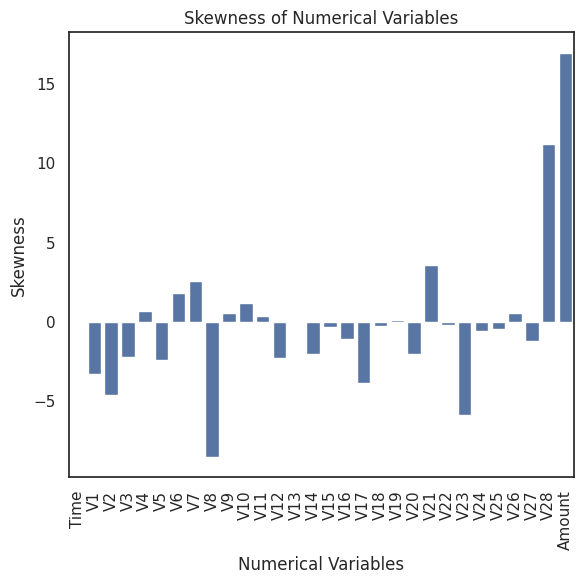

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.xticks(rotation=90)
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.xlabel('Numerical Variables')
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Variables')
plt.tight_layout()
plt.show()

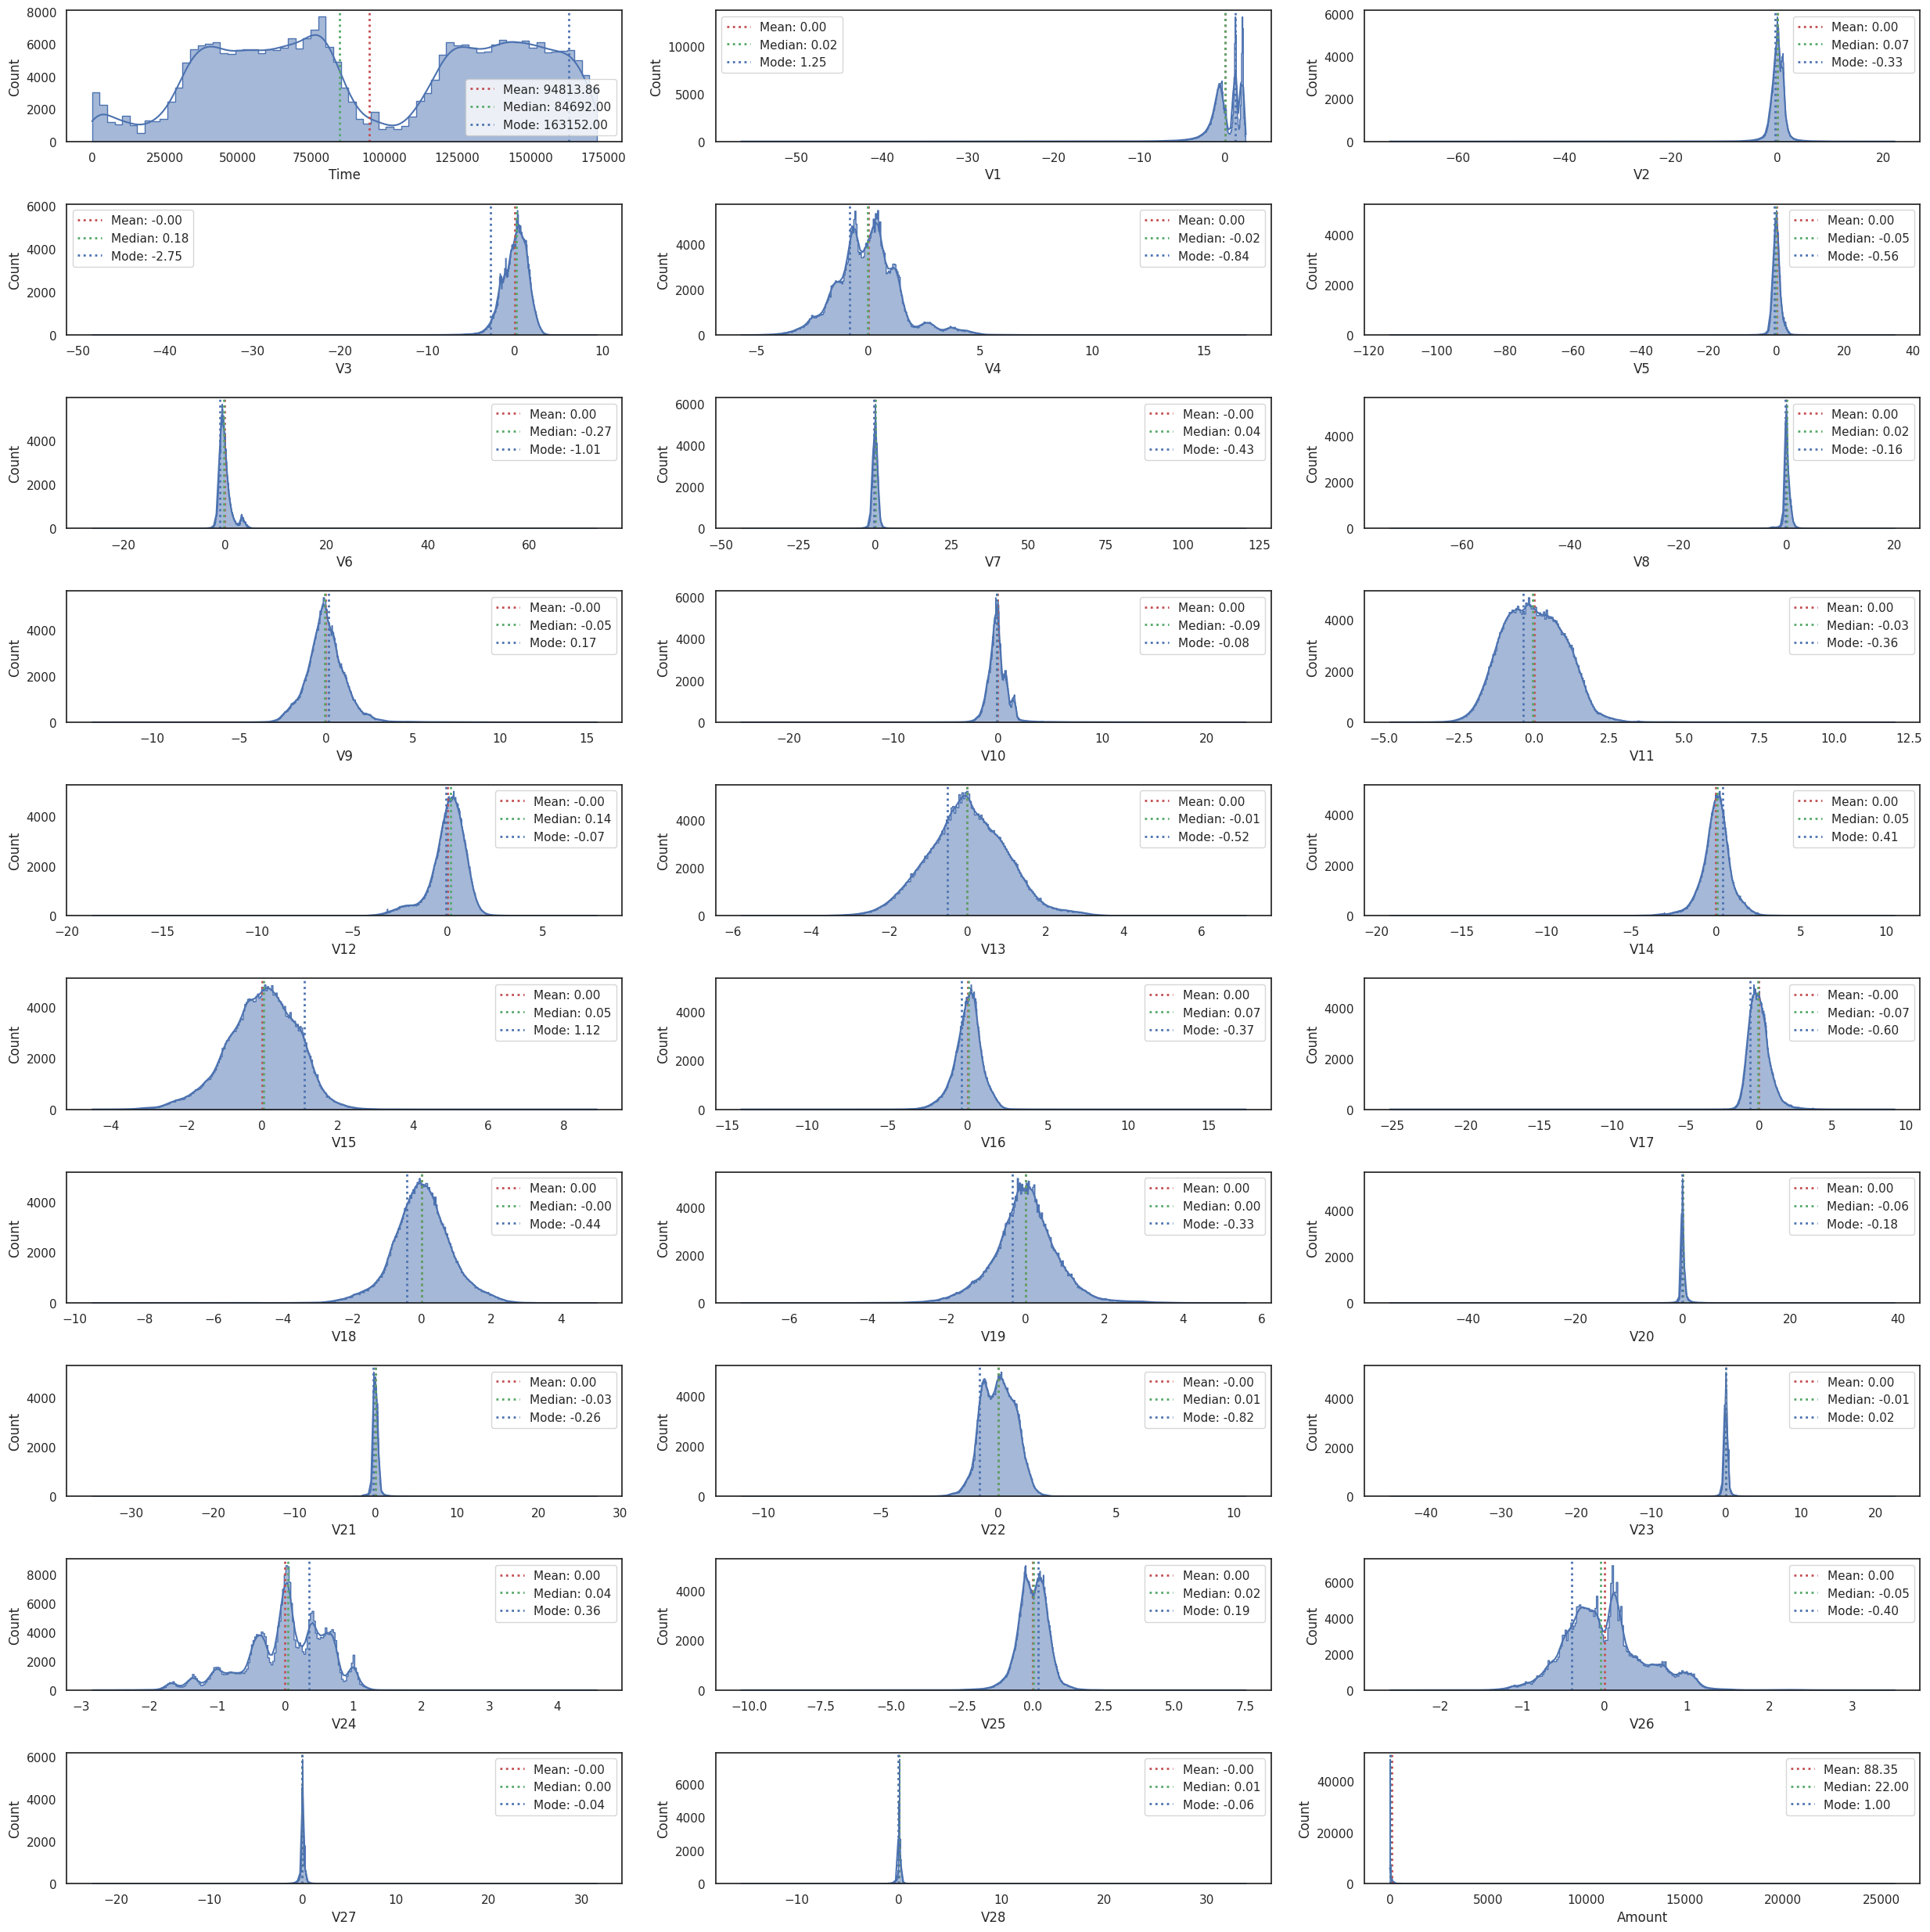

In [ ]:
fig, axs = plt.subplots(nrows = np.ceil(len(numerical_cols)/3).astype(int), ncols = 3, figsize = (25,25))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
  sns.histplot(dataset[col], kde=True, element="step", ax=axs[i])

  mean_value = dataset[col].mean()
  median_value = dataset[col].median()
  mode_value = dataset[col].mode()[0]
  axs[i].axvline(mean_value, color='r', linestyle=':', linewidth=2, label=f'Mean: {mean_value:.2f}')
  axs[i].axvline(median_value, color='g', linestyle=':', linewidth=2, label=f'Median: {median_value:.2f}')
  axs[i].axvline(mode_value, color='b', linestyle=':', linewidth=2, label=f'Mode: {mode_value:.2f}')
  axs[i].legend()

# Hide the unutilized axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(pad=1.5)
plt.show()

### Correlation Analysis

Compute pairwise correlation of columns, using Pearson correlation coefficient.

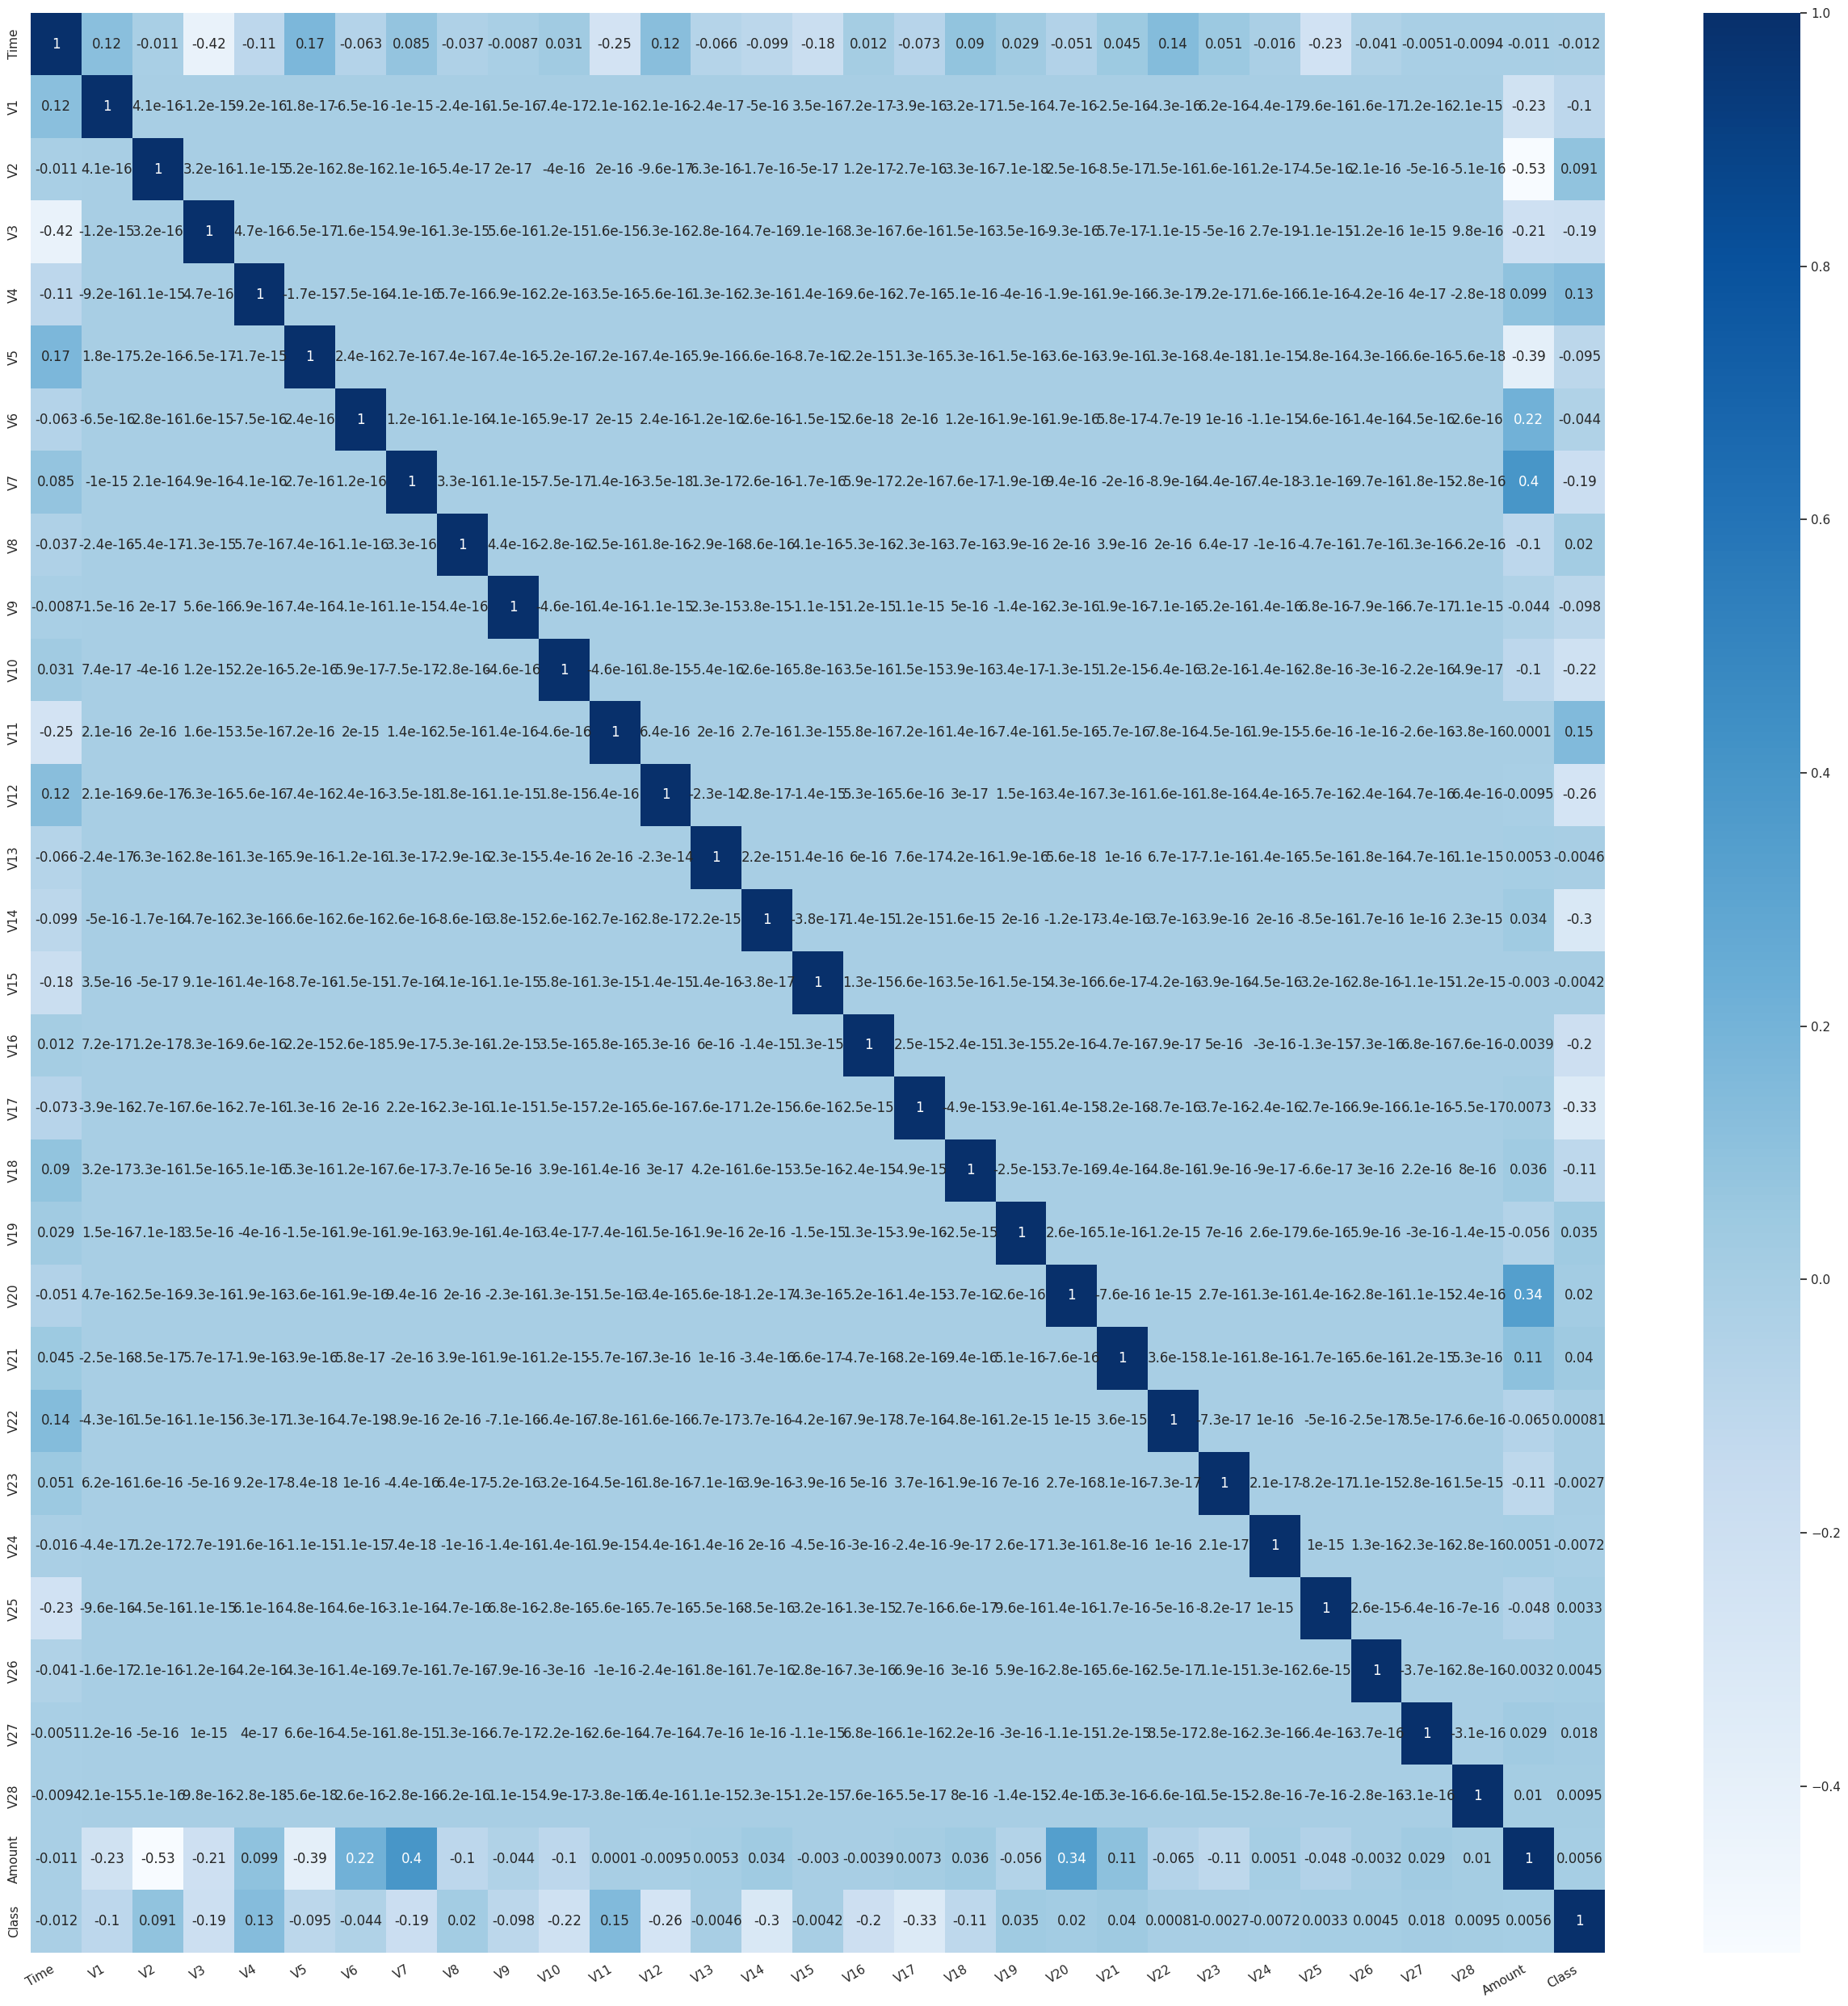

In [ ]:
corrmat = dataset.corr(numeric_only=True)

fig, axs = plt.subplots(figsize=(25, 25))
sns.heatmap(corrmat, annot=True, cmap="Blues")
plt.xticks(rotation=30, ha='right')
fig.tight_layout()
plt.show()

### Majority class downsampling
Due to the limitations of the free usage plans on Colab and Kaggle, it was necessary to perform downsampling. The majority class was downsampled.

In [17]:
dataset['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [18]:
n_samples = 10_000
dataset = pd.concat([
    dataset[dataset['Class']==1],
    dataset.loc[
        np.random.choice(
            (dataset[dataset['Class']==0]).index, n_samples, replace=False)]])

### Dataset splitting
The dataset was split into training, validation and test sets, with proportions of 70%, 15% and 15%, respectively.

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset.iloc[:, :-1],
    dataset.iloc[:, -1],
    test_size = 0.15,
    random_state = seed
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.1764,
    random_state = seed
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(dataset):.2%})")
print(f"Validation set size: {len(X_valid)} ({len(X_valid)/len(dataset):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(dataset):.2%})")

del X_train_val, y_train_val

Training set size: 7344 (70.00%)
Validation set size: 1574 (15.00%)
Test set size: 1574 (15.00%)


### Missing values

In [ ]:
dataset_na = (dataset.isna().sum() / len(dataset)) * 100
dataset_na = dataset_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':dataset_na})
missing_data

Missing Ratio
Time              0.0
V16               0.0
Amount            0.0
V28               0.0
V27               0.0
V26               0.0
V25               0.0
V24               0.0
V23               0.0
V22               0.0
V21               0.0
V20               0.0
V19               0.0
V18               0.0
V17               0.0
V15               0.0
V1                0.0
V14               0.0
V13               0.0
V12               0.0
V11               0.0
V10               0.0
V9                0.0
V8                0.0
V7                0.0
V6                0.0
V5                0.0
V4                0.0
V3                0.0
V2                0.0
Class             0.0

There are no missing values.

### Data normalization

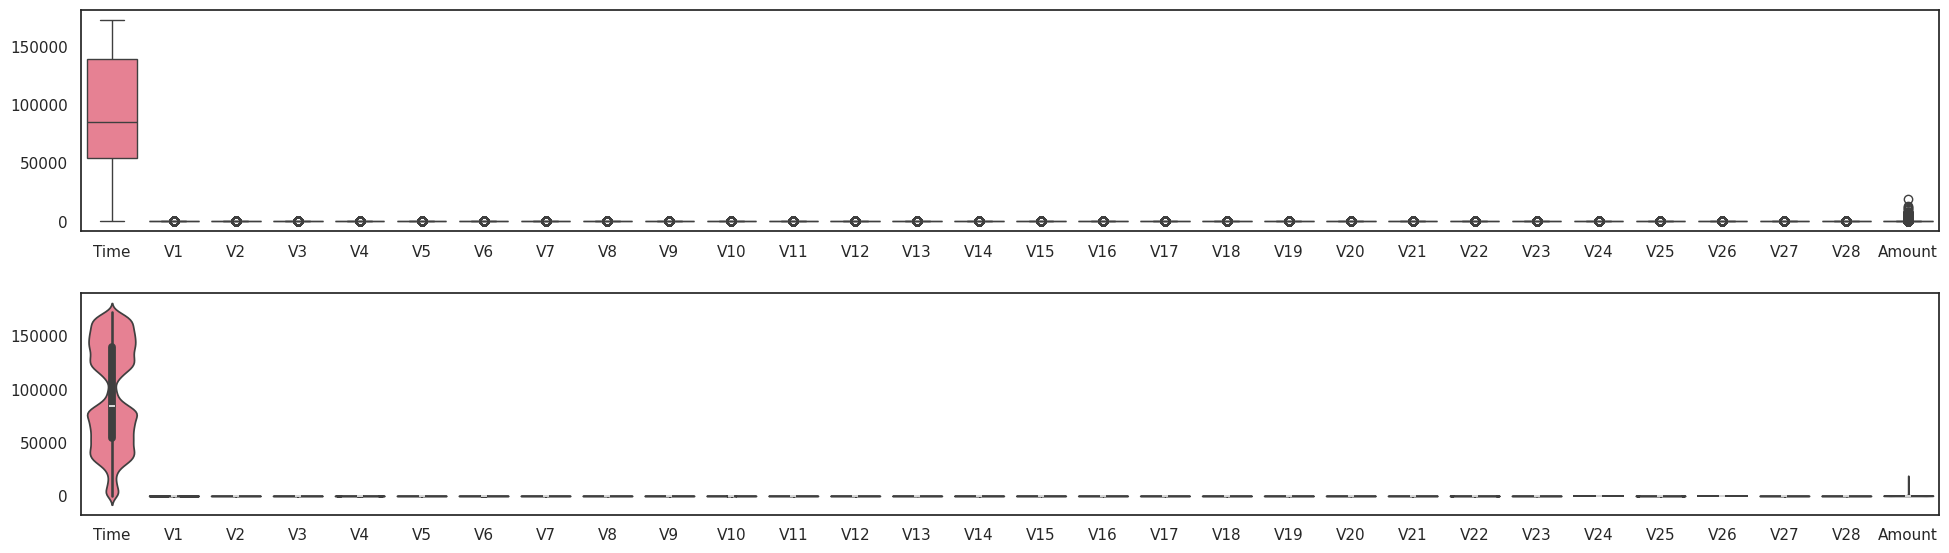

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### Standard Scaler
Standardize features by removing the mean and scaling to unit variance

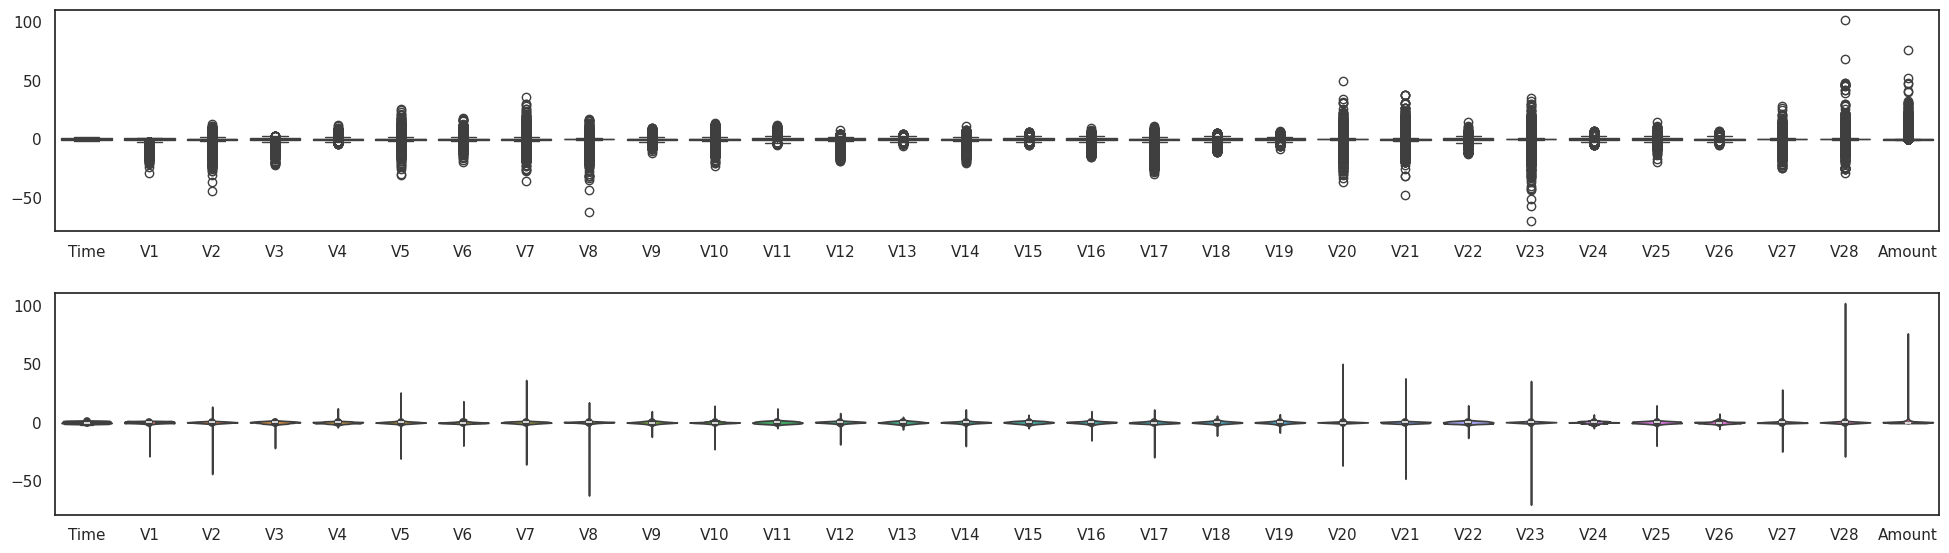

In [ ]:
X_train_scaled = X_train.copy()
scaler = StandardScaler().fit(X_train[numerical_cols])
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train_scaled, ax=axs[0])
sns.violinplot(data=X_train_scaled, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

#### QuantileTransformer
StandardScaler is sensitive to outliers, as it relies on the mean and standard deviation for scaling, which can be significantly influenced by extreme values. In contrast, QuantileTransformer mitigates the impact of outliers by using quantiles information.
QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution within the range [0, 1], making outliers indistinguishable from inliers.

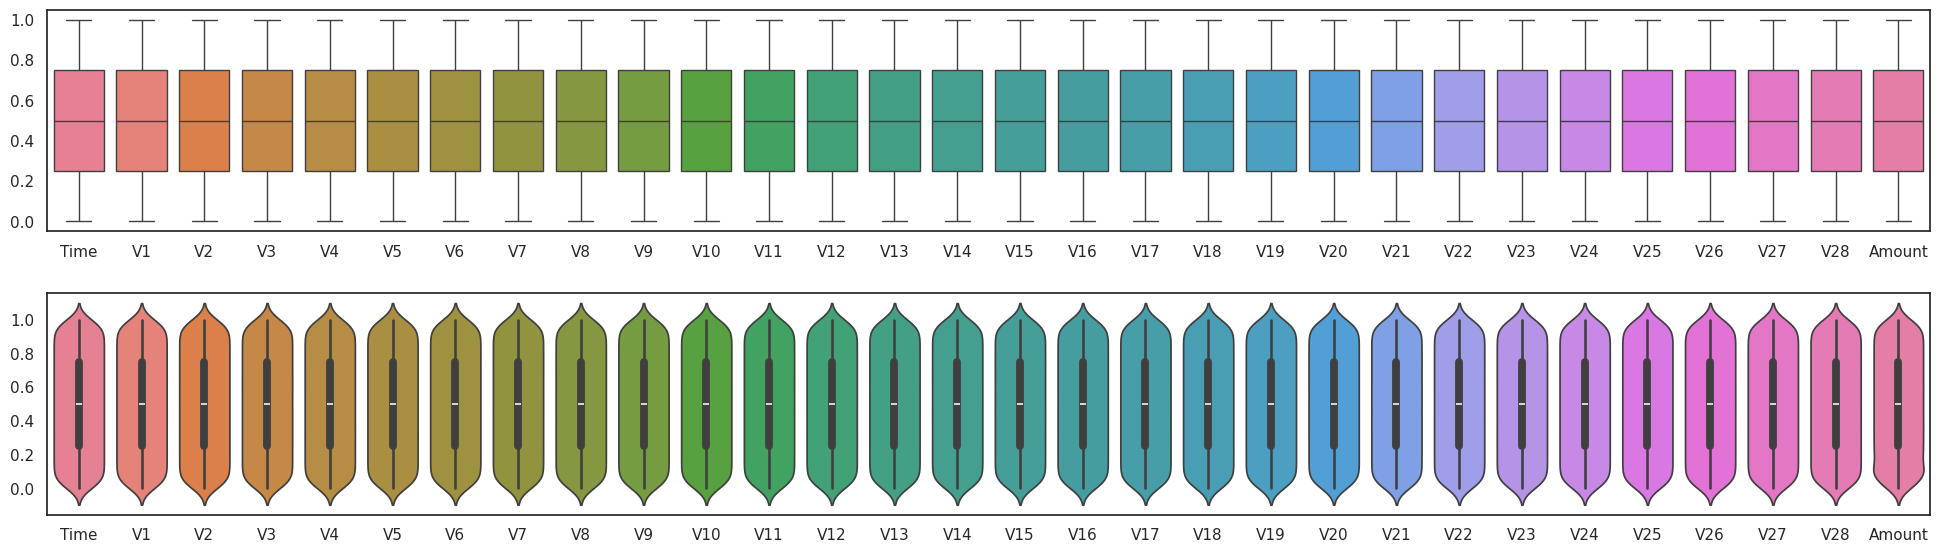

In [20]:
scaler = QuantileTransformer(random_state=seed).fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])

X_valid[numerical_cols] = scaler.transform(X_valid[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,6))
sns.boxplot(data=X_train, ax=axs[0])
sns.violinplot(data=X_train, ax=axs[1])
plt.tight_layout(pad=2)
plt.show()

## HybridIG-CSO algorithm

### Attribute Ranking using IG technique
The Information Gain values were calculated in a separate notebook and exported to a .json file, as the computation for continuous numerical attributes required too much time.

In [21]:
with open(path + 'dataset4_ig_values.json', 'r') as json_file:
    ig_values = json.load(json_file)
ig_values

{'Time': 0.0002519614062057446,
 'V1': 0.0017671709037714346,
 'V2': 0.003678169433608696,
 'V3': 0.005912907795954539,
 'V4': 0.005108151793088607,
 'V5': 0.002420076273797745,
 'V6': 0.00252382819620859,
 'V7': 0.004683173608279075,
 'V8': 0.0013437802314402413,
 'V9': 0.004587660437262596,
 'V10': 0.009732589437849763,
 'V11': 0.008466809336709041,
 'V12': 0.009701682287892038,
 'V13': 6.314851675104718e-05,
 'V14': 0.010741248716738431,
 'V15': 5.7317228542207166e-05,
 'V16': 0.00692093524597473,
 'V17': 0.010984166607051857,
 'V18': 0.004712483224020165,
 'V19': 0.0010753814693910228,
 'V20': 0.0009197442074763522,
 'V21': 0.0024630065241036565,
 'V22': 0.00020030529854355925,
 'V23': 0.0003738681248073271,
 'V24': 0.00011762025901746603,
 'V25': 0.00023690825269010243,
 'V26': 6.190585087654729e-05,
 'V27': 0.0023093443815894697,
 'V28': 0.0013809028504514313,
 'Amount': 0.0006587844953293322}

In [22]:
# Compute the standard deviation of the Information Gain (IG) values
threshold = np.std(list(ig_values.values()))
print(f"\nThreshold: {threshold}")
# Select attributes exceeding or meeting the threshold
ig_attributes = [col for col, ig in ig_values.items() if ig >= threshold]
print(f"Attributes exceeding or meeting the threshold: {ig_attributes}")


Threshold: 0.003467404689859238
Attributes exceeding or meeting the threshold: ['V2', 'V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']


### Hyperparameter tuning
Hyperparameter tuning was performed in a separate notebook.

In [24]:
# The threshold for the sigmoid activation function (classifying predictions as positive if they exceed the threshold and negative otherwise)
threshold = 0.5

# Hyperparameter tuning
alpha, beta, gamma, phi = 1, 0.5, 0.001, 0.1

## Experiment I: Comparisons performance between HybridIG-CSO, RWN with filter approach, and RWN with CSO
In this experiment, the HybridIG-CSO method was evaluated by comparing it with three distinct techniques: the classical RWN, RWN with a filter-based approach (IG-RWN) and manually tuned CSO-RWN. The performance of the HybridIG-CSO method was assessed against the other approaches using six different metrics: Accuracy, Precision, Recall, AUC, F1 and G-mean.

Due to the limitations of the free usage plans on Colab and Kaggle, it was necessary to significantly reduce the number of features, as the initialization of the RWN exhausted all the available RAM. Consequently, it was not feasible to implement the classical RWN and the manually tuned CSO-RWN, as these require the use of the full dataset's features.

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, IGRWN_scores = experiment1(
  ig_attributes,
  X_train, y_train,
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9701
Precision            |     0.8824
Recall               |     0.6696
F1-Score             |     0.7614
Sensitivity          |     0.8824
Specificity          |     0.9752
G-Mean               |     0.9276
AUC                  |     0.9288

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9784
Precision            |     0.8941
Recall               |     0.7525
F1-Score             |     0.8172
Sensitivity          |     0.8941
Specificity          |     0.9832
G-Mean               |     0.9376
AUC                  |     0.9387


### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, IGRWN_scores = experiment1(
  ig_attributes,
  X_train, y_train,
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9212
Precision            |     0.9253
Recall               |     0.9339
F1-Score             |     0.9268
Sensitivity          |     0.9253
Specificity          |     0.9170
G-Mean               |     0.9170
AUC                  |     0.9211

IG-RWN 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9651
Precision            |     0.9502
Recall               |     0.9794
F1-Score             |     0.9645
Sensitivity          |     0.9502
Specificity          |     0.9800
G-Mean               |     0.9649
AUC                  |     0.9651


## Experiment II: Comparison with other classifiers
In this experimental evaluation, the effectiveness of the HybridIG-CSO is assessed in the context of fraud classification, by comparing its performance against other widely employed algorithms typically used as induction techniques in feature selection wrapper-based methods, namely Naïve Bayes (NB), Random Forest (RF) and Support Vector Machine (SVM).

### Testing on a separate test set

In [ ]:
HIGCSO_best_scores, NB_best_scores, RF_best_scores, SVM_best_scores = experiment2(
    ig_attributes,
    X_train, y_train,
    X_test, y_test,
    categorical_cols, n_features,
    alpha, beta, gamma, phi, threshold)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9701
Precision            |     0.8824
Recall               |     0.6696
F1-Score             |     0.7614
Sensitivity          |     0.8824
Specificity          |     0.9752
G-Mean               |     0.9276
AUC                  |     0.9288

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9886
Precision            |     0.8353
Recall               |     0.9467
F1-Score             |     0.8875
Sensitivity          |     0.8353
Specificity          |     0.9973
G-Mean               |     0.9127
AUC                  |     0.9163

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9886
Precision            |     0.8706
Recall               |     0.9136
F1-Score             |     0.8916
Sensitivity

### Testing with 10-Fold Cross-Validation
In the paper, testing stage employed a 10-fold cross-validation approach.

In [ ]:
# Provides train/test indices to split data in train/test sets
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

HIGCSO_best_scores, RWN_scores, IGRWN_scores, CSORWN_best_scores = experiment2(
  ig_attributes,
  X_train, y_train,
  X_test, y_test,
  categorical_cols, n_features,
  alpha, beta, gamma, phi, threshold, kf=kf)

HybridIG-CSO 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9212
Precision            |     0.9253
Recall               |     0.9339
F1-Score             |     0.9268
Sensitivity          |     0.9253
Specificity          |     0.9170
G-Mean               |     0.9170
AUC                  |     0.9211

Naïve Bayes (NB) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9160
Precision            |     0.8358
Recall               |     0.9955
F1-Score             |     0.9086
Sensitivity          |     0.8358
Specificity          |     0.9962
G-Mean               |     0.9124
AUC                  |     0.9160

Random Forest (RF) 
Metric               |      Value
--------------------------------------------------
Accuracy             |     0.9938
Precision            |     0.9906
Recall               |     0.9969
F1-Score             |     0.9937
Sensitivity

In [ ]:
del dataset, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, categorical_cols, kf, ig_values, ig_attributes, alpha, beta, gamma, phi, threshold